# Import

In [8]:
#path_essentials = '/Users/Setup3-PC/Desktop/qudi/logic/setup3_logic/script_logic_essentials.py'
path_essentials = 'jupyter/Timo/from_Simon/script_logic_essentials.py'
path_toolkit = 'jupyter/Timo/own/logic_toolkit.py'
path_curdir = 'jupyter/Timo/own/'
import os, time, sys
import numpy as np

from logic.mfl_irq_driven import MFL_IRQ_Driven
#from logic.mfl_na_irq_driven import MFL_NonAdapt_IRQ_Driven
#from importlib import reload
#reload(mfl_irq_driven)

# import essentials via run
exec(open(path_essentials).read())
exec(open(path_toolkit).read())
# usual module imports
sys.path.append(path_curdir)


import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

# configure this notebook
config_matplotlib_jupyter()

memory_dict=OrderedDict()
print_welcome_msg()



In [8]:
awg8190.set_sample_rate(8e9)   # save memory

8000000000.0

# Common parameters

In [11]:
# MW parameters
common_rabi_period = 72.9e-9 #M2 149.1e-9#760e-9#245.5e-9 #159.5e-9
common_mw_freq =  825.5e6 #M2 1503.592e6 #M15, 1507.455e6  #1507.747#7e6  #1503.336e6  #2656.5e6#NV M3 1.497129e9 #NV M2 1.503316e9 
common_mw_amp = 0.25#0.25

# Readout
# RELOAD logic_essentials and upload new seq when changing!
common_t_laser = 1500e-9 #750e-9# 750e-9   # 600 shortest possible (see mes)
common_t_laser_pulsed = 3000e-9   # for pulsed mes (non NI acq)

# Ramsey
common_mw_ramsey_offset = 1000e3   # Hz, detuning, 
common_mw_ramsey_off_from_calib = 1340e3 #0.1e6 #[0.66e6, 0.72e6]   # Hz, detuning,taken for checking valid

# MFL
common_mfl_tau_step = 50e-9
common_mfl_z_thres = 135.0e-3#51.5e-3

# MFL Ramsey
common_mfl_z_thres_at_cts = -1   # laser_on cts after calibration, used for rescaling, -1 to disable
common_mfl_t2star = 9e-6  # NV M37.5e-6 #NV M2 14e-6

common_mfl_z_last_median = None
common_mfl_freq_max_mhz = 1/(2*common_mfl_tau_step)/1e6   # avoid errors due to Shannon limit
#common_mfl_freq_max_mhz = 6.667   # fix
common_mfl_eta_assym = None

# MFL Hahn
common_mfl_t2 = 120e-6     # for Hahn MFL
common_mfl_hahn_a_par_mhz = 0.283   # must be < than mfl_freq_max_mhz
common_mfl_hahn_b0_gauss = (2.87e9-common_mw_freq)/2.8e6


# Library

## Basics

In [14]:
import pickle
    
def setup_podmr_params(f_res, p_scale=10, p_scale_onlyperiod=1, f_step=0.1e6, n_f=50, t_pi_manual=None):
    # @param p_scale_onlyperiod: scales rabi period according to given power factor.
    #                            useful, if externally controlling poewr
    qmeas=OrderedDict()
    qmeas['name'] = 'Pulsed_ODMR'
    setup['laser_length'] = common_t_laser_pulsed
    if t_pi_manual:
        qmeas['rabi_period'] = 2*t_pi_manual
    else:
        qmeas['rabi_period'] = common_rabi_period*p_scale*p_scale_onlyperiod
    qmeas['freq_step'] = f_step
    qmeas['num_of_points'] = n_f
    qmeas['freq_start'] = f_res - (qmeas['freq_step'] * qmeas['num_of_points'])/2.
    if p_scale != 1:
        qmeas['microwave_amplitude'] = common_mw_amp/(2.*p_scale)
    else:
        qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['measurement_time'] = 1500 
    qmeas['optimize_time'] = None
    qmeas['fit_experiment'] = 'lor_dip'
    
    return qmeas


def setup_rabi_params(tau_step=None, p_scale=1):
    
    qmeas=OrderedDict()
    qmeas['name'] = 'Rabi'
    setup['laser_length'] = common_t_laser_pulsed
    
    if tau_step is None:   
        tau_step = 5e-9
    qmeas['tau_step'] = tau_step
    qmeas['tau_start'] = 0e-9
    qmeas['num_of_points'] = 50
    qmeas['microwave_frequency'] = common_mw_freq #+ 0.5*3.03e6
    if p_scale != 1:
        qmeas['microwave_amplitude'] = common_mw_amp/(2.*p_scale)
    else:
        qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['measurement_time'] = None
    qmeas['optimize_time'] = None
    qmeas['freq_optimize_time'] = None
    #qmeas['fit_experiment'] = None  #'cosine'
    #qmeas['analysis_interval'] = 3
    #qmeas['n_sweeps'] = 5
    
    return qmeas

def setup_ramsey_params(tau_start=100e-9, n_tau=1, tau_step=None):
    qmeas=OrderedDict()
    qmeas['name'] = 'Ramsey'
    setup['laser_length'] = common_t_laser_pulsed
    
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['tau_start'] = tau_start
    if tau_step is None:
        qmeas['tau_step'] = 50e-9
    else:
        qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    qmeas['alternating'] = False
    
    qmeas['from_list'] = False
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'sine_decay'
 
    return qmeas

def setup_xy8_tausweep_params(tau_start=100e-9, n_tau=20, tau_step=None, xy8_order=1, alternating=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'xy8_tau'
    setup['laser_length'] = common_t_laser_pulsed
    
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    
    qmeas['xy8_order'] = xy8_order
    qmeas['tau_start'] = tau_start
    if tau_step is None:
        qmeas['tau_step'] = 100e-9
    else:
        qmeas['tau_step'] = tau_step
        
    
    qmeas['num_of_points'] = n_tau
    qmeas['alternating'] = alternating
    
    qmeas['from_list'] = False
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'Lorentz dip'
 
    return qmeas

def setup_xy8_nsweep_params(tau=500e-9, n_n=20, xy8_start=1, xy8_step=1, alternating=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'xy8_nsweep'
    setup['laser_length'] = common_t_laser_pulsed
    
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    
    qmeas['tau'] = tau
    qmeas['xy8_start'] = xy8_start
    qmeas['xy8_step'] = xy8_step

        
    
    qmeas['num_of_points'] = n_n
    qmeas['alternating'] = alternating
    
    qmeas['from_list'] = False
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_n > 1:
        qmeas['fit_experiment'] = 'sine_decay'
 
    return qmeas

def setup_ramsey_pj_params(tau_start=50e-9, tau_step=50e-9, n_tau=10, tau_list=[], tau_first_epoch=50e-9,
                           n_sweeps=1e3, n_epochs=15, phase_list=[]):
    # pj: pattern jump
    qmeas=OrderedDict()
    qmeas['name'] = 'mfl_ramsey_pjump'
    qmeas['sequence_mode'] = True
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['from_list'] = False
    qmeas['tau_start'] = tau_start
    if tau_step is None and tau_list:
        tau_step = np.diff(np.unique(tau_list)).min()
    qmeas['tau_step'] = tau_step
    qmeas['tau_list'] = tau_list    
    qmeas['phase_list'] = phase_list
    qmeas['n_sweeps'] = None     # for qudi control logic (slow)
    qmeas['n_seq_sweeps'] = n_sweeps   # awg sequence step repetitions (fast)
    qmeas['tau_first'] = tau_first_epoch
    qmeas['num_of_points'] = n_tau    # all available tau on AWG to jump to
    qmeas['alternating'] = False
    qmeas['n_epochs'] = n_epochs
    
    qmeas['optimize_time'] = None
    qmeas['timer_interval'] = 100 # s, basically disable
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    
    # (fast) counter settings
    # todo: single sweeps not working as expected atm
    #qmeas['ctr_single_sweeps'] = True
    #qmeas['ctr_n_sweeps'] = 96e3
    qmeas['bin_width'] = 16e-9  # default is 4e-9, speed up data transfer
    # ni_gate_length < 0 to disable nicard as fastcounter
    qmeas['ni_gate_length'] = 600e-9 #  # do not confuse with (fastcounter) gated mode
    setup['laser_length'] = common_t_laser
    
    logger.debug("setup so far {}".format(qmeas))
    
    if tau_step > abs(1./common_mw_ramsey_offset / 4.):
        logger.warn("tau_step= {} might undersample Ramsey fringe expected with period {}".format(tau_step, 1./common_mw_ramsey_offset))
    
    if qmeas['ni_gate_length']:
        if qmeas['ni_gate_length'] > 0:  # will use nicard as fastcounter
            counterlogic.stopCount()
            logger.debug("counter stop")
     
    logger.info("Checking for 'gated' settings. Currently recommended: \
                qudi cfg: (always) False, jupyter setup: False (True for fastcomtec 2d aquisition)")
    
    if setup['gated'] and qmeas['ni_gate_length'] > 0:
        logger.error("Ni counting should not be combined with (fastcomtec) gated mode.")
    if setup['gated']:
        qmeas['gate_channel'] = 'd_ch1'
        qmeas['sync_channel'] = None
        qmeas['ctr_n_cycles'] = n_epochs # fast counter cycles, y axis in 2d gated array
        qmeas['ctr_n_sweeps'] = n_sweeps
    else:
        qmeas['gate_channel'] = None
        qmeas['sync_channel'] = 'd_ch1'
    
    qmeas['trig_in_pol'] = 'neg'   # for awg8190 polarity of advancement trigger (see labbook 23.6.20)
    
    return qmeas


def setup_hahn_pj_params(tau_start=50e-9, tau_step=50e-9, n_tau=10, tau_list=[], tau_first_epoch=50e-9,
                           n_sweeps=1e3, n_epochs=15):
    # pj: pattern jump
    qmeas=OrderedDict()
    qmeas['name'] = 'mfl_hahn_pjump'
    qmeas['sequence_mode'] = True
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq 
    qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['from_list'] = False
    qmeas['tau_start'] = tau_start
    qmeas['tau_step'] = tau_step
    qmeas['tau_list'] = tau_list
    qmeas['n_sweeps'] = None     # for qudi control logic (slow)
    qmeas['n_seq_sweeps'] = n_sweeps   # awg sequence step repetitions (fast)
    qmeas['tau_first'] = tau_first_epoch
    qmeas['num_of_points'] = n_tau    # all available tau on AWG to jump to
    qmeas['alternating'] = False
    qmeas['n_epochs'] = n_epochs
           
    qmeas['optimize_time'] = None
    qmeas['timer_interval'] = 9999 # s, basically disable
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    
    # (fast) counter settings
    # todo: single sweeps not working as expected atm
    #qmeas['ctr_single_sweeps'] = True
    #qmeas['ctr_n_sweeps'] = 96e3
    qmeas['bin_width'] = 16e-9  # default is 4e-9, speed up data transfer
    # ni_gate_length < 0 to disable nicard as fastcounter
    qmeas['ni_gate_length'] = 600e-9 #  # do not confuse with (fastcounter) gated mode
    setup['laser_length'] = common_t_laser
    
    logger.debug("setup so far {}".format(qmeas))
    
    if qmeas['ni_gate_length']:
        if qmeas['ni_gate_length'] > 0:  # will use nicard as fastcounter
            counterlogic.stopCount()
            logger.debug("counter stop")
     
    logger.info("Checking for 'gated' settings. Currently recommended: \
                qudi cfg: (always) False, jupyter setup: False (True for fastcomtec 2d aquisition)")
    
    if setup['gated'] and qmeas['ni_gate_length'] > 0:
        logger.error("Ni counting should not be combined with (fastcomtec) gated mode.")
    if setup['gated']:
        qmeas['gate_channel'] = 'd_ch1'
        qmeas['sync_channel'] = None
        qmeas['ctr_n_cycles'] = n_epochs # fast counter cycles, y axis in 2d gated array
        qmeas['ctr_n_sweeps'] = n_sweeps
    else:
        qmeas['gate_channel'] = None
        qmeas['sync_channel'] = 'd_ch1'
    
    qmeas['trig_in_pol'] = 'neg'
    
    return qmeas

def setup_xy8_pj_params(tau_start=50e-9, tau_step=50e-9, n_tau=10, tau_list=[], tau_first_epoch=50e-9, n_first_epoch=1,
                           n_sweeps=1e3, n_epochs=15, phase_list=[], xy8_n_start=1, xy8_n_stop=4, xy8_n_step=1,
                       alternating=False):
    # pj: pattern jump
    qmeas=OrderedDict()
    qmeas['name'] = 'mfl_xy8_pjump'
    qmeas['sequence_mode'] = True
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['from_list'] = False
    qmeas['tau_start'] = tau_start
    if tau_step is None and tau_list:
        tau_step = np.diff(np.unique(tau_list)).min()
    qmeas['tau_step'] = tau_step
    qmeas['tau_list'] = tau_list    
    qmeas['phase_list'] = phase_list
    qmeas['n_sweeps'] = None     # for qudi control logic (slow)
    qmeas['n_seq_sweeps'] = n_sweeps   # awg sequence step repetitions (fast)
    qmeas['tau_first'] = tau_first_epoch
    qmeas['num_of_points'] = n_tau    # all available tau on AWG to jump to
    qmeas['alternating'] = False
    qmeas['n_epochs'] = n_epochs
    qmeas['xy8_n_start'] = xy8_n_start
    qmeas['xy8_n_stop'] = xy8_n_stop
    qmeas['xy8_n_step'] = xy8_n_step
    qmeas['n_first'] = n_first_epoch
    qmeas['alternating'] = alternating
    
    qmeas['optimize_time'] = None
    qmeas['timer_interval'] = 100 # s, basically disable
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    
    # (fast) counter settings
    # todo: single sweeps not working as expected atm
    #qmeas['ctr_single_sweeps'] = True
    #qmeas['ctr_n_sweeps'] = 96e3
    qmeas['bin_width'] = 16e-9  # default is 4e-9, speed up data transfer
    # ni_gate_length < 0 to disable nicard as fastcounter
    qmeas['ni_gate_length'] = 600e-9 #  # do not confuse with (fastcounter) gated mode
    setup['laser_length'] = common_t_laser
    
    logger.debug("setup so far {}".format(qmeas))
    
    if tau_step > abs(1./common_mw_ramsey_offset / 4.):
        logger.warn("tau_step= {} might undersample Ramsey fringe expected with period {}".format(tau_step, 1./common_mw_ramsey_offset))
    
    if qmeas['ni_gate_length']:
        if qmeas['ni_gate_length'] > 0:  # will use nicard as fastcounter
            counterlogic.stopCount()
            logger.debug("counter stop")
     
    logger.info("Checking for 'gated' settings. Currently recommended: \
                qudi cfg: (always) False, jupyter setup: False (True for fastcomtec 2d aquisition)")
    
    if setup['gated'] and qmeas['ni_gate_length'] > 0:
        logger.error("Ni counting should not be combined with (fastcomtec) gated mode.")
    if setup['gated']:
        qmeas['gate_channel'] = 'd_ch1'
        qmeas['sync_channel'] = None
        qmeas['ctr_n_cycles'] = n_epochs # fast counter cycles, y axis in 2d gated array
        qmeas['ctr_n_sweeps'] = n_sweeps
    else:
        qmeas['gate_channel'] = None
        qmeas['sync_channel'] = 'd_ch1'
    
    qmeas['trig_in_pol'] = 'neg'   # for awg8190 polarity of advancement trigger (see labbook 23.6.20)
    
    return qmeas



def run_pdomr(mes_params):
    
    up_to = (mes_params['freq_start'] + mes_params['freq_step'] * mes_params['num_of_points'])
    laser_off()
    do_experiment(experiment='pulsedodmr', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=True, save_tag='PulsedOdmr_'+str(round(mes_params['freq_start']))+'_'+str(up_to),load_tag='')

def run_rabi(mes_params):
    laser_off()
    do_experiment(experiment='rabi', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='Rabi_'+str(round(mes_params['microwave_amplitude']*1000))+'mV',load_tag='')

def run_xy8_tausweep(mes_params):
    laser_off()
    do_experiment(experiment='xy8_tau', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='xy8-o={}_tau_'.format(mes_params['xy8_order']),load_tag='')

def run_xy8_nsweep(mes_params):
    laser_off()
    do_experiment(experiment='xy8_nsweep', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='xy8_tau={}_nsweep'.format(mes_params['tau']),load_tag='')

       
    
def run_ramsey(mes_params, n_sweeps_stop=0):
    
    if n_sweeps_stop > 0:
        # else don't stop by sweeps
        run_ramsey_pj_params['n_sweeps'] = n_sweeps_stop
    
    laser_off()
    do_experiment(experiment='ramsey', qm_dict=mes_params, meas_type=conventional_measurement, 
        meas_info=add_conventional_information, generate_new=True, save_tag='Ramsey',load_tag='')   
    
    if get_current_pulsed_mes_running():
        logger.warning("Mes still running after do_experiment().")
        return (None, None)
    
    else:
        mes = get_current_pulsed_mes()
        x = mes.signal_data[0]
        y = mes.signal_data[1]
        
    return (x,y)  

def run_ramsey_pj(mes_params, prepare_only=False, generate_new=True, save_tag='Ramsey_pjump'):
    
    logger.debug("Running ramsey_pj. prepare_only: {}, generate_new: {}".format(prepare_only, generate_new))
    do_experiment(experiment='mfl_ramsey_pjump', qm_dict=mes_params, meas_type=conventional_measurement, 
        meas_info=add_sequence_mode_info, generate_new=generate_new, save_tag=save_tag, load_tag='', prepare_only=prepare_only)   
    
    if get_current_pulsed_mes_running():
        logger.warning("Mes still running after do_experiment().")
        return (None, None)
    
    else:
        mes = get_current_pulsed_mes()
        # don't need for irq driven
        x = None
        y = None
        
    return (x,y)   

def run_hahn_pj(mes_params, prepare_only=False, generate_new=True, save_tag='Hahn_pjump'):
    
    logger.debug("Running hahn_pj. prepare_only: {}, generate_new: {}".format(prepare_only, generate_new))
    laser_off()
    do_experiment(experiment='mfl_hahn_pjump', qm_dict=mes_params, meas_type=conventional_measurement, 
        meas_info=add_sequence_mode_info, generate_new=generate_new, save_tag=save_tag, load_tag='', prepare_only=prepare_only)   
    
    if get_current_pulsed_mes_running():
        logger.warning("Mes still running after do_experiment().")
        return (None, None)
    
    else:
        mes = get_current_pulsed_mes()
        # don't need for irq driven
        x = None
        y = None
        
    return (x,y)  


def run_xy8_pj(mes_params, prepare_only=False, generate_new=True, save_tag='xy8_pjump'):
    
    logger.debug("Running xy8_pj. prepare_only: {}, generate_new: {}".format(prepare_only, generate_new))
    laser_off()
    do_experiment(experiment='mfl_xy8_pjump', qm_dict=mes_params, meas_type=conventional_measurement, 
        meas_info=add_sequence_mode_info, generate_new=generate_new, save_tag=save_tag, load_tag='', prepare_only=prepare_only)   
    
    if get_current_pulsed_mes_running():
        logger.warning("Mes still running after do_experiment().")
        return (None, None)
    
    else:
        mes = get_current_pulsed_mes()
        # don't need for irq driven
        x = None
        y = None
        
    return (x,y)  

def run_mfl_separate_thread(repeat_last_mfl=False, n_sweeps=1e5, n_epochs=100, calibmode_lintau=False,
                            tau_s_list=None, n_tau=20, tau_step=100e-9, tau_list=[], nowait_callback=False):
    # @param repeat_last_mfl: use last AWG assets, only if sequences haven't changed!

    tau_first_epoch = 1/(2*common_mfl_freq_max_mhz*1e6)
    
    tau_start = 25e-9

    cts_current = 0
    z_thresh = rescale_z_thresh(common_mfl_z_thres, cts_current, -1)

    params_dict = {'n_sweeps': n_sweeps, 'n_epochs': n_epochs, 'z_thresh': z_thresh,
                   't2star': common_mfl_t2star, 'calibmode_lintau': calibmode_lintau,
                   'freq_max_mhz': common_mfl_freq_max_mhz, 'nowait_callback': nowait_callback,
                   'eta_assym': common_mfl_eta_assym}
    logger.info("Starting mfl in seperate thread. Params {}".format(params_dict))
    
    uglobals.abort.clear()
    laser_off()   # otherwise no upload possible
    # hangs, for what reason what so ever
    #pulsedmasterlogic.pulsedmeasurementlogic().timer_interval = 1e6
    qmeas = setup_ramsey_pj_params(n_sweeps=n_sweeps, tau_start=tau_start, tau_step=tau_step, n_tau=n_tau, 
                                   tau_first_epoch=tau_first_epoch, n_epochs=n_epochs, tau_list=tau_list)
    qmeas['lock_file_done'] = 'temp/done.lock'  # done signal from external thread
    
    logger.debug("Prepare mes for mfl in seperate thread. Mes dict {}".format(qmeas))
    
    # sample sequences and export them
    # don't save from logic essential, do manually after run
    run_ramsey_pj(qmeas, generate_new=not repeat_last_mfl, prepare_only=True, save_tag=None)   # for saving jumptable
    logger.info("Done sampling first time to export info for jumptable")
    export_meta_dict = export_jupyter_vars(params_dict)
    export_meta_dict = export_qudi_vars(export_meta_dict)   # now jumptable can be pulled
    logger.debug("Exporting meta_dict {}".format(export_meta_dict))
    
    global lock_last_mes
    lock_last_mes = export_meta_dict['lock_file']
    logger.debug("Saving in notebook lock of current sepearte mes {}".format(lock_last_mes))
    
    # start real measurement 
    #laser_on() 
    #optimize_position()   # hangs up atm
    #laser_off()

    run_ramsey_pj(qmeas, generate_new=False, prepare_only=False, save_tag=None)

def run_mfl_nonadapt_seperate_thread(repeat_last_mfl=False, n_sweeps=1e5, calibmode_lintau=False,
                                 n_tau=20, na_g=1, na_f=0, na_opt_phase=True, 
                                 nowait_callback=False, n_epochs=None, tau_short_to_long=True):
    

    na_n_taus = n_tau
    
    # only to generate from sepearte instance of qudi module
    # not passing any param to sepearte thread!
    mfl_na_logic = MFL_NonAdapt_IRQ_Driven(None, no_super=True, manager=None, name=None)
    mfl_na_logic.init_mfl_algo(na_g=na_g, na_f=na_f, na_n_taus=na_n_taus, na_opt_phase=na_opt_phase,
                               tau_short_to_long=tau_short_to_long,
                              freq_max_mhz=common_mfl_freq_max_mhz)
    tau_list, phase_list = mfl_na_logic.generate_tau_and_phase()
    
    logger.info("Non-adaptive MFL, g={}, f={}, taus= {}, read_phases= {}".format(na_g, na_f, tau_list, phase_list))

    if not n_epochs:
        n_epochs=n_tau   # works for G=1, F=0 only!
    
    cts_current = 0
    z_thresh = rescale_z_thresh(common_mfl_z_thres, cts_current, -1)

    params_dict = {'n_sweeps': n_sweeps, 'n_epochs': n_epochs, 'z_thresh': z_thresh,
                   'na_g': na_g, 'na_f': na_f, 'na_n_taus': na_n_taus, 'na_opt_phase': na_opt_phase, 
                   't2star': common_mfl_t2star, 'calibmode_lintau': calibmode_lintau,
                   'freq_max_mhz': common_mfl_freq_max_mhz, 'nowait_callback': nowait_callback,
                   'eta_assym': common_mfl_eta_assym, 'tau_short_to_long': tau_short_to_long}
    
    
    logger.info("Starting mfl in seperate thread. Params {}".format(params_dict))
    
    uglobals.abort.clear()
    laser_off()   # otherwise no upload possible
    # hangs, for what reason what so ever
    #pulsedmasterlogic.pulsedmeasurementlogic().timer_interval = 1e6
    tau_0 = 1/(common_mfl_freq_max_mhz*1e6)
    qmeas = setup_ramsey_pj_params(n_sweeps=n_sweeps, tau_start=tau_0, tau_step=None, n_tau=n_tau, 
                                   tau_first_epoch=tau_list[0], n_epochs=n_epochs, tau_list=tau_list,
                                   phase_list=phase_list)
    qmeas['lock_file_done'] = 'temp/done.lock'  # done signal from external thread
    
    logger.debug("Prepare mes for mfl in seperate thread. Mes dict {}".format(qmeas))
    
    # sample sequences and export them
    # don't save from logic essential, do manually after run
    run_ramsey_pj(qmeas, generate_new=not repeat_last_mfl, prepare_only=True, save_tag=None)   # for saving jumptable
    logger.info("Done sampling first time to export info for jumptable")
    export_meta_dict = export_jupyter_vars(params_dict)
    export_meta_dict = export_qudi_vars(export_meta_dict)   # now jumptable can be pulled
    logger.debug("Exporting meta_dict {}".format(export_meta_dict))
    
    global lock_last_mes
    lock_last_mes = export_meta_dict['lock_file']
    logger.debug("Saving in notebook lock of current sepearte mes {}".format(lock_last_mes))
    
    # start real measurement 
    #laser_on() 
    #optimize_position()   # hangs up atm
    #laser_off()

    run_ramsey_pj(qmeas, generate_new=False, prepare_only=False, save_tag=None)
    

def run_mfl_hahn_separate_thread(repeat_last_mfl=False, n_sweeps=1e5, n_epochs=100, calibmode_lintau=False,
                            tau_s_list=None, n_tau=20, tau_step=100e-9, tau_list=[], nowait_callback=False):
    # @param repeat_last_mfl: use last AWG assets, only if sequences haven't changed!

    tau_first_epoch = 25e-9
    
    tau_start = 25e-9

    cts_current = 0
    z_thresh = rescale_z_thresh(common_mfl_z_thres, cts_current, -1)
    c_scale_2 = 0.999   # fixes the np.sin(phi01) term
    
    params_dict = {'n_sweeps': n_sweeps, 'n_epochs': n_epochs, 'z_thresh': z_thresh,
                   't2': common_mfl_t2, 'calibmode_lintau': calibmode_lintau,
                   'freq_max_mhz': common_mfl_freq_max_mhz, 'phi_max': np.pi, 'nowait_callback': nowait_callback,
                   'b0_gauss': common_mfl_hahn_b0_gauss, 'a_parallel_mhz': common_mfl_hahn_a_par_mhz,
                   'c_scale': c_scale_2}
    logger.info("Starting mfl in seperate thread. Params {}".format(params_dict))
    
    uglobals.abort.clear()
    laser_off()   # otherwise no upload possible
    # hangs, for what reason what so ever
    #pulsedmasterlogic.pulsedmeasurementlogic().timer_interval = 1e6
    qmeas = setup_hahn_pj_params(n_sweeps=n_sweeps, tau_start=tau_start, tau_step=tau_step, n_tau=n_tau, 
                                   tau_first_epoch=tau_first_epoch, n_epochs=n_epochs, tau_list=tau_list)
    qmeas['lock_file_done'] = 'temp/done.lock'  # done signal from external thread
    
    logger.debug("Prepare mes for mfl in seperate thread. Mes dict {}".format(qmeas))
    
    # sample sequences and export them
    # don't save from logic essential, do manually after run
    run_hahn_pj(qmeas, generate_new=not repeat_last_mfl, prepare_only=True, save_tag=None)   # for saving jumptable
    logger.info("Done sampling first time to export info for jumptable")
    export_meta_dict = export_jupyter_vars(params_dict)
    export_meta_dict = export_qudi_vars(export_meta_dict,
                                        seq_name='mfl_hahn_pjump', step_name='mfl_hahn_pjump')   # now jumptable can be pulled
    logger.debug("Exporting meta_dict {}".format(export_meta_dict))
    
    global lock_last_mes
    lock_last_mes = export_meta_dict['lock_file']
    logger.debug("Saving in notebook lock of current sepearte mes {}".format(lock_last_mes))
    
    # start real measurement 
    #laser_on() 
    #optimize_position()   # hangs up atm
    #laser_off()

    run_hahn_pj(qmeas, generate_new=False, prepare_only=False, save_tag=None)


def run_mfl_xy8_separate_thread(repeat_last_mfl=False, n_sweeps=1e5, n_epochs=100, calibmode_lintau=False,
                            tau_s_list=None, n_tau=20, tau_start=500e-9, tau_step=100e-9, tau_list=[], nowait_callback=False,
                               xy8_n_start=1, xy8_n_stop=4, xy8_n_step=1):
    # @param repeat_last_mfl: use last AWG assets, only if sequences haven't changed!
    
    tau_start = tau_start
    # todo: does hard coding make sense here?
    tau_first_epoch = tau_start
    n_first_epoch = 1
    
    

    cts_current = 0
    z_thresh = rescale_z_thresh(common_mfl_z_thres, cts_current, -1)
    c_scale_2 = 0.999   # fixes the np.sin(phi01) term
    
    params_dict = {'n_sweeps': n_sweeps, 'n_epochs': n_epochs, 'z_thresh': z_thresh,
                   't2': common_mfl_t2, 'calibmode_lintau': calibmode_lintau,
                   'freq_max_mhz': common_mfl_freq_max_mhz, 'phi_max': np.pi, 'nowait_callback': nowait_callback,
                   'b0_gauss': common_mfl_hahn_b0_gauss, 'a_parallel_mhz': common_mfl_hahn_a_par_mhz,
                   'c_scale': c_scale_2}
    logger.info("Starting mfl in seperate thread. Params {}".format(params_dict))
    
    uglobals.abort.clear()
    laser_off()   # otherwise no upload possible
    # hangs, for what reason what so ever
    #pulsedmasterlogic.pulsedmeasurementlogic().timer_interval = 1e6
    qmeas = setup_xy8_pj_params(n_sweeps=n_sweeps, tau_start=tau_start, tau_step=tau_step, n_tau=n_tau, 
                                   tau_first_epoch=tau_first_epoch, n_first_epoch=n_first_epoch,
                                   n_epochs=n_epochs, tau_list=tau_list,
                                   xy8_n_start=xy8_n_start, xy8_n_stop=xy8_n_stop, xy8_n_step=xy8_n_step,
                                   alternating=True)
    qmeas['lock_file_done'] = 'temp/done.lock'  # done signal from external thread
    
    logger.debug("Prepare mes for mfl in seperate thread. Mes dict {}".format(qmeas))
    
    # sample sequences and export them
    # don't save from logic essential, do manually after run
    run_xy8_pj(qmeas, generate_new=not repeat_last_mfl, prepare_only=True, save_tag=None)   # for saving jumptable
    logger.info("Done sampling first time to export info for jumptable")
    export_meta_dict = export_jupyter_vars(params_dict)
    export_meta_dict = export_qudi_vars(export_meta_dict,
                                        seq_name='mfl_xy8_pjump', step_name='mfl_xy8_pjump')   # now jumptable can be pulled
    logger.debug("Exporting meta_dict {}".format(export_meta_dict))
    
    global lock_last_mes
    lock_last_mes = export_meta_dict['lock_file']
    logger.debug("Saving in notebook lock of current sepearte mes {}".format(lock_last_mes))
    
    # start real measurement 
    #laser_on() 
    #optimize_position()   # hangs up atm
    #laser_off()

    run_xy8_pj(qmeas, generate_new=False, prepare_only=False, save_tag=None)
    
def create_temp_dir():
    #qudi_dir = os.getcwd()
    
    folder_dir = 'temp'
    try:
        os.mkdir(folder_dir)
    except FileExistsError as e:
        pass   # already exists
    
    return folder_dir 
    
    
def export_qudi_vars(meta_dict=None, seq_name='mfl_ramsey_pjump', step_name='mfl_ramsey_pjump'):
        
    folder_dir = create_temp_dir()
    file_name_meta = folder_dir + '/' + 'mfl_meta.pkl'
    file_name_seq =  folder_dir + '/' + 'pulse_sequence.pkl'
    file_name_pg_settings = folder_dir + '/' + 'pulse_generator_settings.pkl' 
    file_name_ens =  folder_dir + '/' + 'pulse_ensembles.pkl'
    
    # meta file describes what to load from mfl_logic
    filename_dict = {'pulse_sequence': file_name_seq, 'pulse_ensembles': file_name_ens, 
                     'pulse_generator_settings': file_name_pg_settings}
    if meta_dict is None:
        meta_dict = {'files': filename_dict}
    else:
        meta_dict.update({'files': filename_dict})
    
    seq = pulsedmasterlogic.sequencegeneratorlogic().saved_pulse_sequences[seq_name]

    ens_dict = {key: val for key, val in pulsedmasterlogic.sequencegeneratorlogic().saved_pulse_block_ensembles.items() if
             step_name in key}      # filter out important  
    pulsegen_settings = pulsedmasterlogic.pulse_generator_settings
    
    with open(file_name_meta, 'wb') as file:
        pickle.dump(meta_dict, file)
    
    with open(file_name_seq, 'wb') as file:
        pickle.dump(seq, file)
        
    with open(file_name_pg_settings, 'wb') as file:
        pickle.dump(pulsegen_settings, file)
    
    with open(file_name_ens, 'wb') as file:
        pickle.dump(ens_dict, file)

    return meta_dict

def export_jupyter_vars(params_dict):
    import string
    import random
    
    folder_dir = create_temp_dir()
    
    file_name_meta = folder_dir + '/' + 'mfl_meta.pkl'
    # for synchronizing start with seperate thread
    rand_str = ''.join([random.choice(string.ascii_letters + string.digits) for n in range(16)])
    file_name_lock = folder_dir + '/' + rand_str + '.lock'
    timestamp = datetime.datetime.now()
    t_start_str = timestamp.strftime('%Y%m%d-%H%M-%S')

    meta_dict = {'t_start': t_start_str, 't_start_raw': timestamp, 'mfl_params': params_dict, 'lock_file': file_name_lock}
    
    with open(file_name_meta, 'wb') as file:
        pickle.dump(meta_dict, file)
    with open(file_name_lock, 'wb') as file:
        pickle.dump({'t_start_raw': timestamp}, file)
    
    return meta_dict
    
def get_counts(t_avg_s=0.1):
    
    # stop refocusing for getting counts
    refocus_running = True
    try:
        if poimanagerlogic.time_until_refocus == -1:
            refocus_running = False
        else:
            poimanagerlogic.toggle_periodic_refocus(False)
    except NameError:
        refocus_running = False
        
    
    f_count = counterlogic.get_count_frequency()
    n_samples = int(t_avg_s * f_count)
    n_samples_max = counterlogic.get_count_length()
    if n_samples > n_samples_max:
        n_samples = n_samples_max
        
    # wait until refocus done for sure
    if refocus_running:
        timeout = False
        timeout_t_s = 5
        t_start = time.time()

        while(time.time() - poimanagerlogic._last_refocus < t_avg_s and not timeout):
            time.sleep(0.1)
            if time.time() - t_start > timeout_t_s:
                timeout = True
                
    cts = np.median(counterlogic.countdata[0][-n_samples:])    # counts per s
    
    if refocus_running:
        poimanagerlogic.toggle_periodic_refocus(True)
    
    return cts
        

def rescale_z_thresh(z, cts, calib_at_counts=0):
    if calib_at_counts <= 0:
        return z
    
    return cts/calib_at_counts * z
    
    
def modify_seqtable(new_val, key, name_filter='', seqname='mfl_ramsey_pjump'):
    seqtable_curr = get_sequence_parameter_list(seqname)
    
    for i, step in enumerate(seqtable_curr):
        step_name = step[0][0]
        step_dict = step[1]
        if name_filter in step_name:
            if key in step_dict:
                val = step_dict[key]
                step_dict[key] = int(new_val)
                logger.debug("Changed seq table entry {} ({}): {}->{}".format(
                    i, step_name, val, new_val))
            
            
    # so far modified sequencegeneratorlogic, write to AWG
    write_sequence(seqname, sequence_param_list=seqtable_curr, load=False)

def estimate_memory_xy8(taus, n_orders, t_rabi=100e-9, alternating=True):
    length_s = 0
    
    for tau in taus:
        for n in n_orders:
            length_s += 8*n*(tau+t_rabi/2)
    
    if alternating:
        return 2*length_s
    return length_s
    

In [17]:
save_subdir_base = None

class Dict2Obj(object):
    """
    Turns a dictionary into a class
    """
    # ----------------------------------------------------------------------
    def __init__(self, dictionary):
        """Constructor"""
        for key in dictionary:
            setattr(self, key, dictionary[key])
    
    def to_dict(self, obj):
        mdict = {}
        accept_types = [np.ndarray, str, bool, float, int, list, tuple]
        for key, var in obj.__dict__.items():
            if type(var) in accept_types:
                mdict[key] = var

        return mdict
    
    def dump(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self.to_dict(self), file)

def get_file_index(path, fname=None, splitchar='.'):
    """
    given a filename ("file.xyz"), return the highest unused index in the save path
    """
    
    from pathlib import Path
    
    is_looking_for_folder = False
    if fname is None: 
        is_looking_for_folder = True
        fname = os.path.basename(path)
        path = Path(path).parents[0]
    if is_looking_for_folder:
        idx_split = -1
    else:
        idx_split = -2
    index = 0
    # print(os.path.splitext(fname)[0])
    for file in os.listdir(path):
        if file.startswith(os.path.splitext(fname)[0]):
            if len(file.split(splitchar)) > abs(idx_split):  # filename has at least one 'middle initial'
                try:
                    fi = int(file.split(splitchar)[idx_split])  # try to convert second-last string into integer
                except:
                    continue
                if fi >= index:
                    index = fi + 1
    return index
            

def plot_mfl_result(true_B_mhz=None, savepath=None, no_show=True, mfl_mes=None):    
    
    save_prelim = False
    if savepath is not None:
        save_prelim = True
        logger.debug("Savepath in plot_mfl_result: {}".format(savepath))
    
    # save preliminarily, as qudi does not support log plots
    timestamp = datetime.datetime.now()
    filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '.png')
    
    
    # B
    plt.figure()
    
    for i, comp in enumerate(B_mhz[1,:]):
        plt.errorbar(x, B_mhz[:,i], yerr=dB_mhz[:,i], label='B')
        
    #plt.plot(dB_mhz, label='dB')
    plt.xlabel('Epoch')
    plt.ylabel('B*gamma (MHz)')
    if(true_B_mhz is not None):
        for tB in true_B_mhz:
            plt.axhline(tB, label='true B', color='green')
    plt.legend(loc='lower left', prop={'size': 8})
    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + '_prelim_B_vs_epoch.png')
        plt.savefig(savepath + '/' + filename)
        logger.info("Saving preliminary plots to {}".format(savepath))
    if not no_show:
        plt.show()
    #print(track_B)
    
    # eta
    eta_seq_ut = eta_seq * 1e6
    eta_phase_ut = eta_phase * 1e6
    eta_real_ut = eta_real * 1e6
    eta_seq_total_ut = eta_seq_total * 1e6
    eta_phase_total_ut = eta_phase_total * 1e6
    eta_real_total_ut = eta_real_total * 1e6

    # eta^2 instantanous
    plt.figure()
    plt.semilogy(eta_phase_ut**2, label='t_phase')
    plt.semilogy(eta_seq_ut**2, label='t_seq')
    plt.semilogy(eta_real_ut**2, label='all overheads')
    plt.title('Instantaneous eta^2, n_sweeps= {}'.format(n_sweeps))
    plt.xlabel('Epoch')
    plt.ylabel('eta^2 (uT/Hz)')
    plt.legend(loc='lower left', prop={'size': 8})
  
    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + '_prelim_eta^2_epoch.png')
        plt.savefig(savepath + '/' + filename)
    if not no_show:
        plt.show()
    
    # eta^2 instantanous
    plt.figure()
    plt.loglog(t_total_phase_s, eta_phase_ut**2, label='eta^2, t_phase')
    plt.loglog(t_total_seq_s, eta_seq_ut**2, label='eta^2, t_seq')
    plt.loglog(t_total_real_s, eta_real_ut**2, label='eta^2, all overheads')
    plt.title('Instantaneous eta^2, n_sweeps= {}'.format(n_sweeps))
    plt.xlabel('Total runtime (s)')
    plt.ylabel('eta^2 (uT/Hz)')
    plt.legend(loc='lower left', prop={'size': 8})
    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + '_prelim_eta^2.png')
        plt.savefig(savepath + '/' + filename)
    if not no_show:
        plt.show()
    
    # eta^2 total
    plt.figure()
    plt.loglog(t_total_phase_s, eta_phase_total_ut**2, label='eta^2, t_phase')
    plt.loglog(t_total_seq_s, eta_seq_total_ut**2, label='eta^2, t_seq')
    plt.loglog(t_total_real_s, eta_real_total_ut**2, label='eta^2, all overheads')
    plt.title('Total eta^2, n_sweeps= {}'.format(n_sweeps))
    plt.xlabel('Total runtime (s)')
    plt.ylabel('eta^2 (uT/Hz)')
    plt.legend(loc='lower left', prop={'size': 8})
    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + '_prelim_eta^2_total.png')
        plt.savefig(savepath + '/' + filename)
    if not no_show:
        plt.show()
    
    # eta total
    plt.figure()
    plt.loglog(t_total_phase_s, 1000*eta_phase_total_ut, label='t_phase, {:.1f}% of total'.format(
            100*t_total_phase_s[-1]/max(t_total_real_s)))
    plt.loglog(t_total_seq_s, 1000*eta_seq_total_ut, label='t_seq, {:.1f}% of total'.format(
            100*t_total_seq_s[-1]/max(t_total_real_s)))
    plt.loglog(t_total_real_s, 1000*eta_real_total_ut, label='all overhead, min= {:.2f} nT'.format(
                1000*min(eta_real_total_ut[eta_real_total_ut > 0.])))
    plt.title('Total eta, n_sweeps= {}'.format(n_sweeps))
    plt.xlabel('Total runtime (s)')
    plt.ylabel('eta (nT/sqrt(Hz))')
    plt.legend(loc='lower left', prop={'size': 8})
    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + '_prelim_eta_total.png')
        plt.savefig(savepath + '/' + filename)
    if not no_show:
        plt.show()
    
    # tau
    plt.figure()
    tau_diff_ns = abs(taus_req - tau_ns)
    plt.scatter(x, tau_ns, marker="x", label='tau', color="blue")
    plt.scatter(x, taus_req, label='requested tau', facecolors='none' ,edgecolors='orange')
    plt.scatter(x, tau_diff_ns, label='|diff|', color="red")
    axes = plt.gca()
    axes.set_yscale('log')
    axes.set_ylim([1,max(taus_req)])
    plt.ylabel('tau (ns)')
    plt.xlabel('Epoch')
    plt.legend(loc='lower left', prop={'size': 8})
    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + '_prelim_tau.png')
        plt.savefig(savepath + '/' + filename)
    if not no_show:
        plt.show()
    #print(track_tau)
    
    plt.figure()
    phase_diff_rad = abs(read_phase_req - read_phase_rad)
    plt.scatter(x, read_phase_rad/np.pi, marker="x", label='phase', color="blue")
    plt.scatter(x, read_phase_req/np.pi, label='requested phase', facecolors='none' ,edgecolors='orange')
    plt.scatter(x, phase_diff_rad/np.pi, label='|diff|', color="red")
    axes = plt.gca()
    axes.set_ylim([0,max(read_phase_req/2)])
    plt.ylabel('phase (rad/pi)')
    plt.xlabel('Epoch')
    plt.legend(loc='lower left', prop={'size': 8})
    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + '_prelim_phase.png')
        plt.savefig(savepath + '/' + filename)
    if not no_show:
        plt.show()
    #print(track_tau)
    
    # tau histogram
    plt.figure()
    n_bins = 35
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    ax0, ax1, ax2, ax4 = axes.flatten()
    # thresholding values for outlier detection
    taus_req_filter = taus_req[taus_req<10*max(tau_ns)]
    tau_diff_filter = tau_diff_ns[tau_diff_ns<10*max(tau_ns)]
    taus_list = [tau_ns, taus_req_filter, tau_diff_filter]
    frac_bigger_t2 = len(taus_req[taus_req>t2_star_s*1e9])/len(taus_req)
    max_tau_s = max(tau_ns)*1e-9
    frac_bigger_maxtau = len(taus_req[taus_req>=max_tau_s*1e9])/len(taus_req)
    
    #logger.info("tau_ns {}, taus_req {}, diff {}".format(tau_ns, taus_req, abs(taus_req - tau_ns)))
    color_list = ['blue', 'orange', 'red']
    label_list = ['tau', None, '|diff|']
    ax1.hist(taus_list[1]/1e3, histtype='bar', color=color_list[1], label=label_list[1], bins=n_bins)
    ax1.set_xlabel('requested (us)')
    ax1.axvline(x=max_tau_s*1e6, label="{:.2f} > max= {:.1f} us".format(frac_bigger_maxtau, max_tau_s*1e6), color='red')
    #frac_bigger_maxtau,
    ax1.axvline(x=t2_star_s*1e6, label="{:.2f} > T2*= {:.1f} us".format(frac_bigger_t2, t2_star_s*1e6), color='grey')
    ax1.set_title('- {} outliers'.format(len(tau_ns) - len(taus_req_filter)))
    ax1.set_yscale('log')
    ax1.legend(bbox_to_anchor=(0.1,-0.2), loc="upper left", prop={'size': 8})  
    
    ax0.hist(taus_list[0]/1e3, histtype='bar', color=color_list[0], label=label_list[0], bins=n_bins)
    ax0.set_xlabel('tau (us)')
    ax0.axvline(x=t2_star_s*1e6, label="T2*", color='grey')
    ax0.set_title('{} taus'.format(len(tau_ns)))
    ax0.set_yscale('log')
    
    _, hist_x, _ = ax2.hist(taus_list[2]/1e3, histtype='bar', color=color_list[2], label=label_list[2], bins=n_bins)
    ax2.set_xlim([min(hist_x), max(hist_x)])
    ax2.set_xlabel('diff (us)')
    ax2.axvline(x=t2_star_s*1e6, label="T2*", color='grey')
    ax2.set_title('- {} outliers'.format(len(tau_ns) - len(tau_diff_filter)))
    ax2.set_yscale('log')
    fig.tight_layout()

    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + '_prelim_tau_hist.png')
        plt.savefig(savepath + '/' + filename)
    if not no_show:
        plt.show()
    
    # reshuffled z vs tau
    plt.figure()
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
    ax0, ax2, ax1 = axes.flatten()
    ax0.scatter(tau_ns, zs)
    z_median = calc_median_z(mfl_mes)
    z_avg = np.average(zs)
    z_var = ma_deviation(zs)
    #print(z_median)
    #print(z_thresh)
    #print(z_var)
    #print('zs, z_median= {:.4f}+-{:.4f}, z_thresh={:.4f}'.format(z_median, z_var, z_thresh))
    plt.suptitle('zs, z_median= {:.4f}+-{:.4f}, z_thresh={:.4f}'.format(z_median, z_var, z_thresh))
    ax0.set_xlabel('tau (ns)')
    ax0.set_ylabel('z (normed to n_sweeps= {:d})'.format(int(n_sweeps)))
    axes = plt.gca()
    axes.set_ylim([min(zs), max(zs)])
    #axes.set_ylim([z_median-2*z_var,z_median+2*z_var])
    ax0.axhline(z_median, label='z_median', color='red')
    ax0.axhline(z_thresh, label='z_thresh', color='green')
    
    hist_y, hist_x, _ = ax1.hist(zs*n_sweeps, bins=len(np.unique(zs)), density=False)
    #print("Debug hist_x: {} hist_y: {}".format(hist_x, hist_y))
    ax1.axvline(z_median*n_sweeps, label='z_median= {}'.format(z_median*n_sweeps), color='red')
    ax1.axvline(z_avg*n_sweeps, label='z_average= {:.3f}'.format(z_avg*n_sweeps), color='orange')
    ax1.set_ylim([0, max(hist_y)])
    ax1.set_xlabel('z (cts)')
    ax1.set_ylabel('hits in {} epochs'.format(len(zs)))
    
    # mean vale for same taus
    import pandas as pd
    d = {'taus': tau_ns.flatten(), 'zs':zs.flatten()}
    df = pd.DataFrame(data=d)
    df_mean = df.groupby('taus', as_index=False).mean()
    ax2.scatter(df_mean.taus, df_mean.zs)
    ax2.axhline(z_median, color='red')
    ax2.axhline(z_thresh, color='green')
    ax2.set_xlabel('tau (ns)')
    ax2.set_ylabel('z_mean')
    # debug: to quickly get mean value for old data, that doesn't contain
    np.savetxt(savepath + '/tau_mean.txt', np.asarray(df_mean.taus))
    np.savetxt(savepath + '/zs_mean.txt', np.asarray(df_mean.zs))
    
    plt.tight_layout()
    
    
    plt.legend(loc='lower left', prop={'size': 8})
    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + '_prelim_zs.png')
        plt.savefig(savepath + '/' + filename)
        
    if not no_show:
        plt.show()
        
    
        
    plt.close('all')

def ma_deviation(a, axis=None):
    """
    Compute *Median Absolute Deviation* of an array along given axis.
    """
    # https://informatique-python.readthedocs.io/fr/latest/Exercices/mad.html
    # Median along given axis, but *keeping* the reduced axis so that
    # result can still broadcast against a.
    med = np.median(a, axis=axis, keepdims=True)
    mad = np.median(np.absolute(a - med), axis=axis)  # MAD along given axis
    return mad
    
def plot_mfl_prior(epochs_idx=[-1], save_prelim=True, savepath=None):
 
        
    save_prelim = False
    if savepath is not None:
        save_prelim = True
        logger.debug("Savepath in plot_priors_2d: {}".format(savepath))
    
    timestamp = datetime.datetime.now()
    
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err=False)
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(priors):
        epoch = i
        if epoch in epochs_idx:
            plt.subplot(n_rows, n_col, idx_plot+1)
            yhits, xbins, patchees = plt.hist(priors[epoch])
            fmin_mhz = np.min(xbins)
            fmax_mhz = np.max(xbins)
            ax1 = plt.gca()
            
            label='Prior {}'.format(epoch)
            plt.title(label)
            plt.xlabel('B*gamma (MHz)')
            plt.ylabel('')
            
            ax2 = ax1.twinx()

            #logger.info("Debug: likelihood f: {}, {}".format(likelihoods[epoch][0],
            #                                            likelihoods[epoch][1]))
            ax2.set_xlim([fmin_mhz, fmax_mhz])
            try:
                ax2.plot(likelihoods[epoch][0], likelihoods[epoch][1], '-', color='orange',
                         label='t= {:.2f} us, \n p= {:.2f} rad/pi'.format(
                             tau_ns[epoch]*1e-3, read_phase_rad[epoch]/np.pi))
            except Exception as e:
                pass 
                #logger.debug("Error in likelihood plotting: {}".format(e))
            handles, labels = ax2.get_legend_handles_labels()
            plt.legend(handles, labels, loc=9, prop={'size': 6})
            
            idx_plot += 1
            #print("Printing prior {}".format(i))
  
    plt.tight_layout()
   
    
        
    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + 'mfl_priors.png')
        plt.savefig(savepath + '/' + filename)
            
    plt.show()


def _get_prior_plotsize(epochs_idx=[], always_show_err=False):
    plot_all = not epochs_idx 
    epochs_error = []  # not known in experiments
    n_plots = len(track_priors) if plot_all else len(epochs_idx)
    n_plots += 2*len(epochs_error)
    n_col = 4
    n_rows = np.ceil(n_plots/n_col) 
    
    return n_rows, n_col
    
def plot_priors_2d_gaussian_heatmap(epochs_idx=[], n_bins=50, savepath=None):
    
    save_prelim = False
    if savepath is not None:
        save_prelim = True
        logger.debug("Savepath in plot_priors_2d: {}".format(savepath))
    
    timestamp = datetime.datetime.now()
    
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err=False)
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(priors):
        epoch = i
        if epoch in epochs_idx:
            particle_locations = priors[epoch]
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            line = plt.hist2d(particle_locations[:,0], particle_locations[:,1], bins=n_bins)
            
            label='Prior {}'.format(epoch)
            plt.title(label)
            plt.xlabel("$\omega_1$ (MHz)")
            plt.ylabel("$\omega_2$ (MHz)")
            
            idx_plot += 1
        
    plt.tight_layout()
    plt.legend(loc='lower left', prop={'size': 8})
    
    if save_prelim:
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + 'mfl_priors_2d_heat.png')
        plt.savefig(savepath + '/' + filename)
            
    plt.show()
    
def load_seperate_thread_results(filename, check_lock=False):

    with open(filename, 'rb') as file:
        mes_dict = pickle.load(file)
    mes = MFL_IRQ_Driven(None, no_super=True, manager=None, name=None)
    mes.__dict__.update(mes_dict)
    
    logger.debug("Loaded {} with keys {}".format(filename, mes.__dict__.keys()))
    
    if check_lock:
        global lock_last_mes
        try:
            mes_loaded_lock = mes.meta_dict['lock_file']
        except Exception as e:
            logger.warning("Could not find lockfile in {}: {}".format(filename, str(e)))
            mes_loaded_lock = None
        if mes_loaded_lock != lock_last_mes:
            logger.warning("Lock of result file {}: {} != expected: {}. Mes might have failed."
                           .format(filename, mes_loaded_lock, lock_last_mes))
            raise OSError("Lockfile does not fit to measurement.")
         
    return mes
    

def get_savepath(next_free=False, postfix=None):
    global save_dir
    savepath = save_dir
    if save_subdir_base is not None:
        #logger.debug("savepath {} . save_subdir_base {}".format(savepath, save_subdir_base))
        savepath = savepath + '/' + save_subdir_base 
        if postfix is not None:
            savepath = savepath + postfix
        if next_free:
            savepath = savepath + '.' + str(get_file_index(save_dir + '/' + save_subdir_base, splitchar='.'))

    logger.info("get_savepath: savepath {}, subdir_base {}, postfix {}".format(savepath, save_subdir_base, postfix))
    
    return savepath

def reset_savedir():
    global save_subdir_base  # base without postfix, not expanded
    global save_subdir       # total foldername (not fully expandes path) with postfix
    global save_dir          # PulseMeasurment dir, expanded
    global save_postfix      # postfix only
    
    save_subdir, save_subdir, save_dir, save_postfix = None, None, None, None


def split_path_to_folder(path):
    # https://stackoverflow.com/questions/3167154/how-to-split-a-dos-path-into-its-components-in-python
    folders = []
    while 1:
        path, folder = os.path.split(path)

        if folder != "":
            folders.append(folder)
        else:
            if path != "":
                folders.append(path)

            break

    folders.reverse()
    return folders

def get_folder_right_of(folder, full_path):
    folder_list = split_path_to_folder(full_path)
    idx_f = folder_list.index(folder)
    
    path_str = ""
    
    for f in folder_list[idx_f+1:]:
        path_str += "/" + f
        
    return path_str
        
    
def set_savedir(folder_basename, postfix=None, overwrite_path=None):
    
    from os.path import normpath, basename
    global save_subdir_base  # base without postfix, not expanded
    global save_subdir       # total foldername (not fully expandes path) with postfix
    global save_dir          # PulseMeasurment dir, expanded
    global save_postfix      # postfix only
    
    save_dir = savelogic.get_path_for_module('PulsedMeasurement')  
    save_subdir_base = folder_basename
    save_postfix = postfix
    savepath = get_savepath(next_free=True, postfix=postfix)  # fully expanded path with postfix   
    
    if overwrite_path is not None:
        save_subdir_base = None
        save_postfix = None
        # split after save_dir
        save_subdir = get_folder_right_of('PulsedMeasurement', overwrite_path)
        savepath = overwrite_path

    
    # change global here, st. logic essentials know where to save parameters to
    savepath_last_folder = basename(normpath(savepath))
    logger.debug("set_savedir: savepath_last_folder {}. savepath {}. subdir_base {}. subdir {}".format(
        savepath_last_folder, savepath, save_subdir_base, save_subdir))
    save_subdir = savepath_last_folder
    
    #os.mkdir(savepath)
    return savepath_last_folder, savepath
  
    
def inject_and_save(x, y, save_tag, y2=None, labels_xy=['',''], units_xy=['',''], dy=None):
    savepath = get_savepath(next_free=True)
    if save_subdir_base is not None:
        savepath = savepath + '/' + save_subdir_base + '/'
            
    with_error = False
    if dy is not None:
        with_error = True
    
    inject_data_to_current_mes(x, y, y2=y2, labels_xy=labels_xy, units_xy=units_xy, dy=dy)
    
    logger.info("{}".format(pulsedmasterlogic.pulsedmeasurementlogic().measurement_settings))
    logger.info("{}, {}".format(labels_xy, units_xy))
    pulsedmasterlogic.save_measurement_data(save_tag, with_error)

  
    
def plot_and_save(mfl_mes, save_mfl_pulsed=(True, True), overwrite_path=None, i_priors=[]):
    
    # overwrite_path: automatically created if None
    # else: a path inside qudi 'PulsedMeasurment' dir
    
    lastB_mhz = mfl_mes.bs[-1,:]
    lastB_str = ''.join("%.3fMHz_" % x for x in lastB_mhz)[0:-1]
    n_sweeps = mfl_mes.n_sweeps
    
    try:
        mode = 'na'
        na_f = mfl_mes.mfl_na_f
        na_g = mfl_mes.mfl_na_g
    except:
        mode = 'mfl'
    
    if overwrite_path is None:
        if mode is 'na':
            postfix = '_n_sweeps={:.0f}_B={}_na_g={}_f={}'.format(n_sweeps, lastB_str, na_g, na_f)
        else:
            postfix = '_n_sweeps={:.0f}_B={}'.format(n_sweeps, lastB_str)
        if not is_valid_result(mfl_mes, allow_rel_error=30e-2):
            postfix = postfix + '_fail'
        savepath_last_folder, savepath = set_savedir('mfl', postfix)
    else:
        savepath_last_folder, savepath = set_savedir('mfl', postfix=None, overwrite_path=overwrite_path)
    
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    
    timestamp = datetime.datetime.now()
    if save_mfl_pulsed[0]:
        plot_mfl_result(true_B_mhz=get_true_B()/1e6, savepath=savepath, mfl_mes=mfl_mes)
    try:
        if mfl_mes.bs.shape[1] == 1:
            plot_mfl_prior(i_priors, savepath=savepath)
        if mfl_mes.bs.shape[1] > 1:
            plot_priors_2d_gaussian_heatmap(i_priors, savepath=savepath)
        
    except (IndexError, TypeError) as e:
        # priors not saved
        pass

    if save_mfl_pulsed[1]:
        # works only for data of today!
        # save as pulsed mes (results injected)
        save_tag = save_tag_0 + '_tau'
        inject_data_to_current_mes(x, tau_ns, labels_xy=['Epoch','tau'], units_xy=['','ns'])
        pulsedmasterlogic.save_measurement_data(save_tag, False, subdir=savepath_last_folder)
        plot_and_saveinject_data_to_current_mes
        dB_mhz_1 = dB_mhz[:,0]
        B_mhz_1 = B_mhz[:,0]
        dB_mhz_2 = None
        B_mhz_2 = None
        if dB_mhz.shape[1] == 2:
            dB_mhz_2 = dB_mhz[:,1]
            B_mhz_2 = B_mhz[:,1]
        elif dB_mhz.shape[1] > 2:
            raise ValueError("Can't handle so many dimensions {}".format(dB_mhz.shape[1]))
                
        save_tag = save_tag_0 + '_b'
        inject_data_to_current_mes(x, B_mhz_1, y2=B_mhz_2, dy=dB_mhz_1, dy2=dB_mhz_2,
                                   labels_xy=['Epoch','B*gamma'], units_xy=['','MHz'])
        pulsedmasterlogic.save_measurement_data(save_tag, True, subdir=savepath_last_folder)
        
        # save all mfl_logic data
        filename = timestamp.strftime('%Y%m%d-%H%M-%S' + '_' + save_tag_0 + '_' + save_tag_mfl_data + '.pkl')
        mfl_mes.dump(savepath + '/' + filename)
        


        
def plot_mfl_calibration(t, y1, y2=None):    
    
    plt.figure()
    
    plt.subplot(121)
    plt.plot(t*1e6, y1)
    if y2 is not None:
        plt.plot(t*1e6, y2)
    plt.xlabel('tau (us)')
    plt.ylabel('z')
    
    z_median = np.median(y1)
    z_avg = np.average(y1)
    if y2 is not None:
        z_median = np.median(np.concatenate([y1, y2]))
        z_avg = np.average(np.concatenate([y1, y2]))
    
    #print("Debug hist_x: {} hist_y: {}".format(hist_x, hist_y))
    plt.axhline(z_median, label='z_median= {:.5f}'.format(z_median), color='red')
    plt.axhline(z_avg, label='z_average= {:.5f}'.format(z_avg), color='orange')

    plt.legend()
    
    plt.subplot(122)
    if y2 is not None:
         plt.plot(t*1e6, y2-y1)
    plt.xlabel('tau (us)')
    plt.ylabel('z2-z1')
    
    plt.tight_layout()
    plt.show()
    #print(track_B)        

    
def calc_median_z(mfl_mes, tau_ns=None, zs=None):
    try:
        mode = 'na'
        na_f = mfl_mes.mfl_na_f
        na_g = mfl_mes.mfl_na_g
    except:
        mode = 'mfl'
    
    if tau_ns is None:
        tau_ns = mfl_mes.taus[:,0]*1e9
    if zs is None:
        zs = mfl_mes.zs

    if mode is 'na':
        # in na: first index after which same tau, same phase is repeated
        idx_taus_repeat_na = np.argmax(tau_ns[1:]) + na_g
        
    if not mode is 'na':
        median = np.median(zs)
    else:
        median = np.median(zs[:idx_taus_repeat_na])
        logger.debug("Median from tau idx 0 to {}".format(int(idx_taus_repeat_na)))
        
    return median
    
def analyze_sep_thread_result(filename='temp/mfl_mes_result.pkl', check_lock=False, overwrite_savedir=None):
    import matplotlib.pyplot as plt
        
    global save_tag_0, save_tag_mfl_data
    #set_savedir('mfl')
    save_tag_0 = 'MFL_irq_driven'
    save_tag_mfl_data = 'mfl_raw'
    is_save_mfl_pulsed = (True, False)   


    load_res_from_file = True
    if filename is None:
        load_res_from_file = False

    if load_res_from_file:
        #folder = 'E:/Data/2019/07/20190718/PulsedMeasurement/mfl_n_sweeps=1e4.0'
        #filename = folder + '/' + '20190718-0928-55_MFL_irq_driven_mfl_raw.pkl'
        mfl_mes = load_seperate_thread_results(filename, check_lock=check_lock)
    else:
        mfl_mes = mfl_logic

    # prepare results, ugly, export to global
    global B_mhz, dB_mhz, tau_ns, taus_req, t_seq_ns, x, zs, z_thresh, priors, n_sweeps, timestamps, t2_star_s
    global t_total_phase_s, t_total_seq_s, timestamps, t_total_phase_s, t_total_seq_s, t_total_real_s
    global eta_phase, eta_seq, eta_real, eta_phase_total, eta_seq_total, eta_real_total
    global common_mfl_z_last_median
    global read_phase_rad, read_phase_req
    global likelihoods

    B_mhz = mfl_mes.bs[:,:]
    dB_mhz =  mfl_mes.dbs[:,:]
        
    try:
        mode = 'na'
        na_f = mfl_mes.mfl_na_f
        na_g = mfl_mes.mfl_na_g
    except:
        mode = 'mfl'
        
    tau_ns = mfl_mes.taus[:,0]*1e9
    taus_req = mfl_mes.taus_requested[:,0]*1e9
    t_seq_ns = mfl_mes.t_seqs[:,0]*1e9    # for single sweep!
    if mode is 'na':
        # in na: first index after which same tau, same phase is repeated
        idx_taus_repeat_na = np.argmax(tau_ns[1:]) + na_g
        
    read_phase_rad = mfl_mes.read_phases[:,0]
    read_phase_req = mfl_mes.read_phases_requested[:,0]
    
    
    x = np.asarray(range(0, len(tau_ns)))
    priors = mfl_mes.priors
    try:
        likelihoods = mfl_mes.likelihoods
    except:
        pass # old data has no likelihoods
    n_sweeps = mfl_mes.n_sweeps
    timestamps = mfl_mes.timestamps
    zs = mfl_mes.zs
    common_mfl_z_last_median = calc_median_z(mfl_mes)

        
    z_thresh = mfl_mes.z_thresh
    #print("MFL_mes.z_thresh {}".format(z_thresh))t2_star_s
    is_t2_none = False
    try:
        t2_star_s = mfl_mes.mfl_t2star_s
    except:
        try:
            t2_star_s = mfl_mes.mfl_t2_s
            logger.warning("Loading T2= {} us as T2*".format(t2_star_s*1e6))
        except:
            is_t2_none = True
    is_t2_none = True if t2_star_s is None else False
    if is_t2_none:
        logger.warning("Found T2*= None; setting T2*= inf.")
        t2_star_s = np.inf
            
            
    #i_plot_priors = np.arange(0, x[-1], 5).tolist()
    i_plot_priors = np.linspace(0, x[-1], 60, dtype=int).tolist()

    
    mfl_mes.calc_sensitivity(use_total_time=True)
    t_total_phase_s, t_total_seq_s, t_total_real_s = mfl_mes.get_total_times()
    if len(t_seq_ns) != len(t_total_real_s):
        logger.warning("Timestamps do not give same lengths as taus. Padding.")
        t_total_real_s = np.pad(t_total_real_s, (0, len(t_seq_ns)-len(t_total_real_s)), mode='constant', constant_values=np.nan)

    # instantaneous (with t of every epoch) and total sensitivity (total runtime so far)
    eta_phase, eta_seq, eta_real = mfl_mes.calc_sensitivity()   # eta real: from epoch timestamps, incl all overhead
    eta_phase_total, eta_seq_total, eta_real_total = mfl_mes.calc_sensitivity(use_total_time=True)
    
    plot_and_save(mfl_mes, save_mfl_pulsed=[True, True], i_priors=i_plot_priors, overwrite_path=overwrite_savedir)
    
    # save logic essentials parameters
    try:
        save_parameters(save_tag='mfl_logic_essentials', save_dict=qm_dict_final)
    except Exception as e:
        logger.warning("Couldn't save parameters: {}".format(str(e)))
    
    reset_savedir()  # don't save in folder of eg. last run

def get_true_B():
    
    if common_mw_ramsey_off_from_calib is not None:
        trueB = common_mw_ramsey_off_from_calib 
    else:
        trueB =  common_mw_ramsey_offset
    
    if np.isscalar(trueB):
        return np.asarray([trueB])   # Hz
    else:
        return np.asarray(trueB)
    
def is_valid_result(mfl_mes, allow_rel_error=1e-1):
    
    true_B_mhz = abs(get_true_B())/1e6
    B_mhz = mfl_mes.bs[-1,:]
    n_params = len(B_mhz)
    
    # if len(true_B_mhz) < len(B_mhz), this will check only defined ones
    is_valid = [True]*n_params
    
    for i, b_comp in enumerate(true_B_mhz.tolist()):
        if abs(B_mhz[i]-b_comp)/B_mhz[i] > allow_rel_error:
            is_valid[i] = False
    
    if not all(is_valid):
        logger.warning("Failing result with B= {} Mhz (true: {} MHz). rel= {} > {}".format(B_mhz,true_B_mhz,abs(B_mhz-true_B_mhz)/B_mhz, allow_rel_error))
        return False
    else:
        return True
    
  

## MFL,  not run from seperate thread

In [17]:
try: 
    mfl_logic
except NameError as e:
    logger.error("Couldn't connect to qudi mfl logic. Module loaded and correctly named?")
    raise e

def run_mfl_pj_calib(n_epochs=25, n_sweeps=10e3, tau_step=50e-9):
    
    logger.info("Starting MFL irq driven, calibration")
    
    mfl_logic.init('mfl_ramsey_pjump', n_sweeps, n_epochs=n_epochs, nolog_callback=False, calibmode_lintau=True)
   
    tau_start = 50e-9
    logger.info("First tau for calib {} ns".format(1e9*tau_start))
    
    qmeas = setup_ramsey_pj_params(n_sweeps=n_sweeps, tau_start=tau_start, tau_step=tau_step, n_tau=n_epochs,
                                   tau_first_epoch=tau_start, n_epochs=n_epochs)
    mfl_logic.save_priors = True   # DEBUG only, might be slow
    # todo: tau_first only rounded, not necesarily on AWG!
    mfl_logic.setup_new_run(tau_start, tau_start)
    run_ramsey_pj(qmeas)
    
    # should end itself, but if user abort:
    mfl_logic.end_run()

def run_mfl_pj(n_epochs=10, n_sweeps=1e3, z_thresh=0.5):
    
    logger.info("Starting MFL irq driven, threshold from Ramsey z={}".format(z_thresh))
    
    mfl_logic.init('mfl_ramsey_pjump', n_sweeps, n_epochs=n_epochs, nolog_callback=True, z_thresh=z_thresh)
    tau_first_req = mfl_logic.get_first_tau()
    #tau_first_req = 3500e-9 # DEBUG
    tau_first = tau_first_req  # PROBLEM would like to get from seqtable, but only created after run started
    # shortest tau mfl algo may choose, problem: shorter than tau_first causes rounding issues
    tau_start = 25e-9
    logger.info("First tau from flat prior {} ns".format(1e9*tau_first))
    
    qmeas = setup_ramsey_pj_params(n_sweeps=n_sweeps, tau_start=tau_start, tau_step=200e-9, n_tau=10, tau_first_epoch=tau_first,
                                   n_epochs=n_epochs)
    mfl_logic.save_priors = True   # DEBUG only, might be slow
    # todo: tau_first only rounded, not necesarily on AWG!
    mfl_logic.setup_new_run(tau_first, tau_first_req)
    run_ramsey_pj(qmeas)
    
    # should end itself, but if user abort:
    mfl_logic.end_run()


def profile_mfl_pj(n_epochs=100):
    """start this function with profiler"""
    # todo: not really working. For profiling, use __main__ code in mfl_lofig
    
    logger.info("Starting MFL irq driven profiling")
    n_sweeps = 1e3
    z_thresh = 0.0
    
    mfl_logic.init('mfl_ramsey_pjump', n_sweeps, n_epochs=n_epochs, nolog_callback=False, z_thresh=z_thresh)
    
    mfl_logic.save_priors = False   
    mfl_logic.setup_new_profile_run()
    
    # send first interrupt
    ucmd.send_ttl(channel_name='/dev1/PFI9')
    
    # should end itself, but if user abort:
    mfl_logic.end_run()
    



Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-c2bc527c5c3c>", line 5, in <module>
    raise e
  File "<ipython-input-17-c2bc527c5c3c>", line 2, in <module>
    mfl_logic
NameError: name 'mfl_logic' is not defined


# Laser options

## Optimize position

In [86]:
laser_on()
optimize_position()

7.654353380203247

## Laser On

In [11]:
#laser_on(pulser_on = False)
laser_on()
counterlogic.startCount()

## Laser Off

In [15]:
laser_off(pulser_on=False)
counterlogic.stopCount()


# Frequency Optimization parameters

In [ ]:
optimize_freq_dict=OrderedDict()
optimize_freq_dict['mw_optimization_method'] = 'pulsedodmr'
optimize_freq_dict['optimize_generate_new'] = False
optimize_freq_dict['save_tag'] = 'optimize_frequency'
optimize_freq_dict['optimize_fit_method'] = 'N15'
optimize_freq_dict['parameters2update'] = {'center': 'microwave_frequency'}

optimize_freq_dict['name'] = 'Pulsed_ODMR'
optimize_freq_dict['rabi_period'] = 1800e-9
optimize_freq_dict['freq_start'] = 4.127e9
optimize_freq_dict['freq_step'] = 0.2e6
optimize_freq_dict['num_of_points'] = 50
optimize_freq_dict['microwave_amplitude'] = common_mw_amp/15
optimize_freq_dict['meas_type'] = conventional_measurement
optimize_freq_dict['meas_info'] = add_conventional_information

optimize_freq_dict['measurement_time'] = 30
optimize_freq_dict['optimize_time'] = None
optimize_freq_dict['optimize_generate_new'] = True

#  Preperation mes

Attention: need to reload logic_essentials when switching between these pulsed mes and MFL (nicard acq)

In [11]:
uglobals.abort.clear()

## Pulsed ODMR

In [62]:
p_scale_manual = 1
uglobals.abort.clear()

if p_scale_manual != 1:
    logger.warning("Manually reduce AWG ampl / AMP gain by a factor of {} / {}!".format(2*p_scale_manual, np.sqrt(2*p_scale_manual)))
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=50, p_scale_onlyperiod=p_scale_manual, f_step=20e3) # range ~ 1 MHz

#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=1, f_step=500e3, n_f=150)     # wide band, ~ 10 MHz
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=5, f_step=500e3, n_f=300)     # wide band, ~ 10 MHz
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=1, f_step=500e3, n_f=75)
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=10, f_step=50e3, n_f=75, t_pi_manual=5e-6) # range ~ 5 MHz
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=20, f_step=25e3, n_f=75, t_pi_manual=8e-6)
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=10, n_f=75)
qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=40, f_step=40e3, n_f=450) # range ~ 3*6 MHz
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=60, f_step=20e3, n_f=100) # range ~ 1 MHz, lowest AWG power

run_pdomr(qmeas)

## Rabi

In [50]:
uglobals.abort.clear()
qmeas = setup_rabi_params(tau_step=5e-9)   # 10e-9
#qmeas = setup_rabi_params(tau_step=250e-9, p_scale=20)
run_rabi(qmeas)

## Ramsey


In [65]:
tau_start = 0.5e-6
n_sweeps = 0#1e3

uglobals.abort.clear()
#qmeas = setup_ramsey_params(tau_start, n_tau=200, tau_step=100e-9)     
qmeas = setup_ramsey_params(tau_start, n_tau=400, tau_step=100e-9)
#qmeas = setup_ramsey_params(tau_start, n_tau=200, tau_step=250e-9)      # 75ns: res like mfl
#qmeas = setup_ramsey_params(tau_start, n_tau=400, tau_step=50e-9)     # high res    
#qmeas = setup_ramsey_params(tau_start, n_tau=400, tau_step=100e-9)     # high res  
x, z = run_ramsey(qmeas, n_sweeps_stop=n_sweeps)
z_binary = 0 #majority_vote(z[0], z_thres=common_mfl_z_thres)

logger.info("Ramsey with offset {} MHz, {} sweeps: {} -> {}".format(common_mw_ramsey_offset/1e6, n_sweeps, z, z_binary))


## XY 8 

tau sweep

In [83]:
tau_start = 0.2e-6

uglobals.abort.clear()
#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=75, tau_step=20e-9, xy8_order=4, alternating=True)     
qmeas = setup_xy8_tausweep_params(tau_start, n_tau=250, tau_step=20e-9, xy8_order=4, alternating=True)
#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=75, tau_step=5e-9, xy8_order=8, alternating=True) 

run_xy8_tausweep(qmeas)

n sweep

In [89]:
tau = 440.0e-9

uglobals.abort.clear()
#qmeas = setup_xy8_nsweep_params(tau, n_n=12, xy8_start=1, xy8_step=640, alternating=True)  # long t_evol, mem limit
qmeas = setup_xy8_nsweep_params(tau, n_n=25, xy8_start=1, xy8_step=1, alternating=True)  

run_xy8_nsweep(qmeas)

In [ ]:
a few xy8 tau sweeps

In [54]:
uglobals.abort.clear()

tau_start = 0.5e-6
xy_orders = np.arange(5, 16, 1)

for i, o in enumerate(xy_orders):
    if uglobals.abort.is_set():
        break
    try:
        #pass
        #"""
        laser_on()
        time.sleep(1)
        optimize_position()
        optimize_position()
        laser_off()
        #"""
    except Exception as e:
        logger.warning("auto XY8 run {}, skipping failed tracking: {}".format(i, str(e)))
    if uglobals.abort.is_set():
        break
        
    qmeas = setup_xy8_tausweep_params(tau_start, n_tau=50, tau_step=20e-9, xy8_order=o, alternating=True)     
    qmeas['measurement_time'] = 180
    run_xy8_tausweep(qmeas)

# MFL

## Reset hung nicard

In [43]:
nicard.reset_hardware()

0

## Calibrate MFL

In [77]:
laser_on()
optimize_position()
optimize_position()
laser_off()

In [79]:
uglobals.abort.clear()
laser_on()
optimize_position()
cts_before = get_counts()
laser_off()
run_mfl_pj_calib(n_epochs=50, n_sweeps=50e3, tau_step=75e-9)

laser_on()
cts_after = get_counts()
print("Cts before/after calibration: {} {}".format(cts_before, cts_after))

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 792, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-79-6ae62848d006>", line 6, in <module>
    run_mfl_pj_calib(n_epochs=50, n_sweeps=50e3, tau_step=75e-9)
NameError: name 'run_mfl_pj_calib' is not defined


### Calibration (seperate thread)
If repeat_last_mfl: Also fixes n_sweeps

In [73]:
laser_on()
optimize_position()
optimize_position()
laser_off()

In [109]:
n_epochs = 245
calibrate_from_last_mfl = True

# settings below are overwritten if calibration from last mfl is run
tau_step= common_mfl_tau_step
#tau_step = 200e-9
n_sweeps = 5e3#15e3  # good for dedicated calibration run, 
n_tau = 100

uglobals.abort.clear()
run_mfl_separate_thread(repeat_last_mfl=calibrate_from_last_mfl, tau_step=tau_step, n_sweeps=n_sweeps, n_epochs=n_tau, n_tau=n_tau, calibmode_lintau=True, nowait_callback=True)

### Calibration Hahn (seperate thread)

In [79]:
n_epochs = 245
calibrate_from_last_mfl = True

# settings below are overwritten if calibration from last mfl is run
tau_step= common_mfl_tau_step
n_tau = 20
n_sweeps = 50e3#15e3  # good for dedicated calibration run, 

uglobals.abort.clear()
run_mfl_hahn_separate_thread(repeat_last_mfl=calibrate_from_last_mfl, tau_step=tau_step, n_sweeps=n_sweeps, n_epochs=n_epochs, n_tau=n_tau, calibmode_lintau=True)

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-79-72271d6d42a9>", line 9, in <module>
    run_mfl_hahn_separate_thread(repeat_last_mfl=calibrate_from_last_mfl, tau_step=tau_step, n_sweeps=n_sweeps, n_epochs=n_epochs, n_tau=50, calibmode_lintau=True)
  File "<ipython-input-65-c4aa47a595cc>", line 502, in run_mfl_hahn_separate_thread
    run_hahn_pj(qmeas, generate_new=not repeat_last_mfl, prepare_only=True, save_tag=None)   # for saving jumptable
  File "<ipython-input-65-c4aa47a595cc>", line 328, in run_hahn_pj
    meas_info=add_sequence_mode_info, generate_new=generate_new, save_tag=save_tag, load_tag='', prepare_only=prepare_only)
  File "<string>", line 161, in do_experiment
  File "<string>", line 320, in prepare_qm
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\pulsed\pulsed_master_logic.py", line 1002, in get_sequence_in

### Calibration XY8 (sep thread)

In [21]:
laser_on()
optimize_position()
optimize_position()
laser_off()

In [27]:
n_epochs = 2*n_tau
calibrate_from_last_mfl = True

# settings below are overwritten if calibration from last mfl is run
tau_step= common_mfl_tau_step
n_sweeps = 15e3#15e3  # good for dedicated calibration run, 

uglobals.abort.clear()
run_mfl_xy8_separate_thread(repeat_last_mfl=calibrate_from_last_mfl, n_sweeps=n_sweeps, n_epochs=n_epochs, n_tau=n_tau, tau_step=tau_step,
                       calibmode_lintau=True, xy8_n_start=1, xy8_n_stop=xy8_order_max, xy8_n_step=1,
                       nowait_callback=True) # nowait only for debug!

### Plot calibration run

Loading C:\Users\Setup3-PC\Desktop\qudi\temp\mfl_mes_result.pkl with sequence mfl_xy8_pjump data
Median= 0.10673333333333333


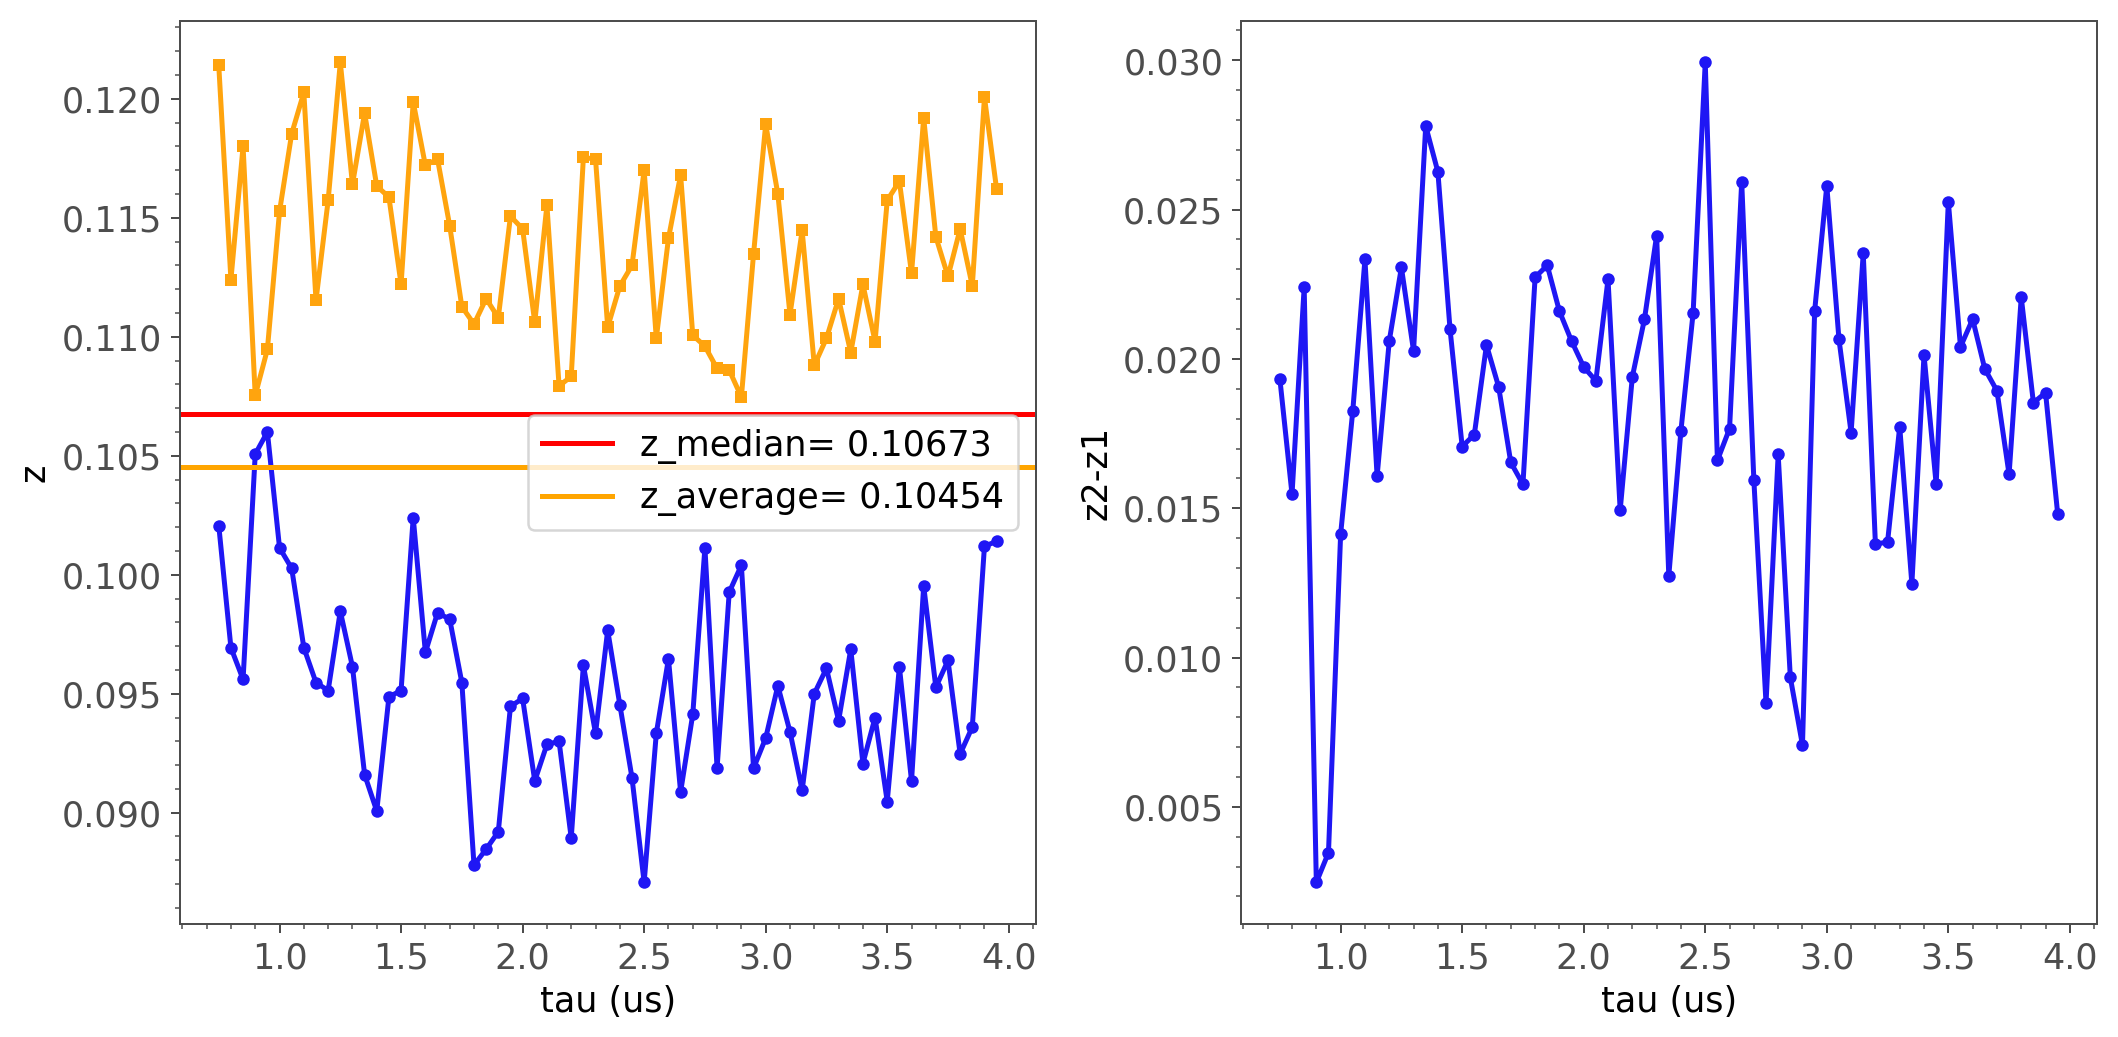

In [103]:
load_res_from_file = True
save_tag = 'calib'

if load_res_from_file:
    file = 'temp/mfl_mes_result.pkl'
    mfl_mes = load_seperate_thread_results(file)
    print("Loading {} with sequence {} data".format(os.path.abspath(file), mfl_mes.sequence_name))
else:
    mfl_mes = mfl_logic

    
savepath_last_folder, savepath = set_savedir('', None)


if 'xy' in mfl_mes.sequence_name:
    # use alternating for calibration
    z = mfl_mes.zs[0::2,0]
    z2 = mfl_mes.zs[1::2,0]
    tau = mfl_mes.taus[0::2,0]
else:
    # todo: think about last element: tau for next epoch (not valid), but z of this epoch
    z = mfl_mes.zs[1:-1,0]
    tau = mfl_mes.taus[1:-1,0]
    z2 = None

    
print("Median= {}".format(calc_median_z(mfl_mes)))
plot_mfl_calibration(tau, z, z2)
#inject_data_to_current_mes(tau, z, labels_xy=['tau','z'], units_xy=['s',''])
# todo: do fit
#inject_and_save(tau, z, save_tag, y2=z2, labels_xy=['tau','z'], units_xy=['s',''])




In [75]:
print(median)

## Run MFL (from qudi)

In [5]:

uglobals.abort.clear()
logger.info("Starting MFL, threshold from Ramsey z={}".format(common_mfl_z_thres))
#reset_mfl()
# 5e5 sweeps ~ mfl_simple
run_mfl_pj(n_epochs=25, n_sweeps=1e3, z_thresh=common_mfl_z_thres)

#laser_on()

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 792, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-6de23daa9444>", line 6, in <module>
    run_mfl_pj(n_epochs=25, n_sweeps=1e3, z_thresh=common_mfl_z_thres)
NameError: name 'run_mfl_pj' is not defined


## Run MFL (separate thread)

Start seperate thread first!

In [69]:
n_epochs = 200
n_sweeps = int(5e3)
tau_step = common_mfl_tau_step
n_tau = 10

#laser_on()
#optimize_position()
#optimize_position()
#laser_off()

run_mfl_separate_thread(repeat_last_mfl=True, n_sweeps=n_sweeps, n_epochs=n_epochs, n_tau=n_tau, tau_step=tau_step,
                       nowait_callback=True)
 

[{"varName": "awg8190", "varType": "AWGM8190A", "varSize": "144", "varShape": "", "varContent": "<hardware.awg.keysight_M8190A.AWGM8190A object at 0x0000001A2A68B678>"}, {"varName": "config", "varType": "OrderedDict", "varSize": "464", "varShape": "", "varContent": "OrderedDict([('hardware', OrderedDict([('dummysmiq', OrderedDict([('module.Class', 'microwave.mw_source_dummy.MicrowaveDummy'), ('gpib_address', 'dummy'), ('gpib_timeout', 20), ('mock', True)])), ('sm"}, {"varName": "confocalgui", "varType": "ConfocalGui", "varSize": "144", "varShape": "", "varContent": "<gui.confocal.confocalgui.ConfocalGui object at 0x0000001A234E7558>"}, {"varName": "countergui", "varType": "CounterGui", "varSize": "144", "varShape": "", "varContent": "<gui.counter.countergui.CounterGui object at 0x0000001A232601F8>"}, {"varName": "counterlogic", "varType": "CounterLogic", "varSize": "144", "varShape": "", "varContent": "<logic.counter_logic.CounterLogic object at 0x0000001A23251E58>"}, {"varName": "fitl

### Upload new 

In [ ]:
tau_list_ns = [16, 18, 19, 21, 25, 30, 36, 40, 52, 57, 66, 67, 85, 87, 91, 118, 121, 128, 130, 141, 176, 188, 190, 193, 200, 205, 210, 217, 252, 253, 261, 267, 272, 308, 309, 317, 371, 452, 465, 492, 493, 556, 640, 646, 651, 692, 725, 726, 850, 855, 885, 889, 895, 946, 956, 1005, 1089, 1242, 1252, 1296, 1378, 1426, 1445, 1467, 1532, 1588, 1596, 1614, 1627, 1648, 1650, 1715, 1731, 1746, 1900, 1944, 2109, 2158, 2264, 2269, 2308, 2335, 2383, 2429, 2566, 2573, 2809, 2858, 2917, 3023, 3137, 3157, 3171, 3181, 3406, 3409, 3632, 3690, 3845, 3959, 4021, 4190, 4246, 4252, 4257, 4304, 4367, 4417, 4441, 4464, 4626, 4659, 4756, 4764, 4801, 4822, 4828, 4930, 4985, 5072, 5132, 5240, 5286, 5334, 5446, 5464, 5535, 5616, 5623, 5676, 5810, 5877, 5879, 6025, 6046, 6087, 6169, 6208, 6296, 6366, 6396, 6557, 6571, 6604, 6609, 6616, 6627, 6695, 6707, 6750, 6752, 6815, 6881, 6972, 7016, 7179, 7282, 7417, 7499, 7546, 7681, 7735, 7820, 8310, 8372, 8484, 8634, 8655, 8743, 8745, 9171, 9256, 9287, 9362, 9562, 9636, 9741, 9774, 9946, 10436, 10623, 10721, 10841, 11082, 11615, 11786, 11967, 12472, 12826, 13028, 13585, 13595, 14263, 14403, 14564, 14609, 15025, 15101, 15213, 15394, 15474, 15891, 15966, 16101, 16275, 16282, 16500, 16538, 16665, 16832, 16917, 18338, 18512, 18579, 18676, 18782, 18793, 18806, 19249, 19369, 20782, 20787, 21112, 22097, 22399, 22760, 22950, 23353, 23503, 23686, 23845, 23924, 24151, 24179, 24501, 24982, 25956, 25957, 26126, 26927, 27260, 27693, 27840, 27953, 28660]
tau_list = [float(el)*1e-9 for el in tau_list_ns]

In [93]:
n_sweeps = 5e3
tau_step = common_mfl_tau_step
#tau_step = 200e-9
n_tau = 100#245

# linear taus
run_mfl_separate_thread(repeat_last_mfl=False, n_sweeps=n_sweeps, n_epochs=100, n_tau=n_tau, tau_step=tau_step)
# custom taus list
#run_mfl_separate_thread(repeat_last_mfl=False, n_sweeps=3e3, n_epochs=50, tau_list=tau_list)

## Run Hahn MFL (separate thread)

In [65]:
n_epochs = 400
n_sweeps = 20e3
tau_step = common_mfl_tau_step
n_tau = 245

laser_on()
optimize_position()
optimize_position()
laser_off()

run_mfl_hahn_separate_thread(repeat_last_mfl=True, n_sweeps=n_sweeps, n_epochs=n_epochs, n_tau=n_tau, tau_step=tau_step,
                       nowait_callback=True)
 

## Run NA-PEA  MFL (seperate thread)

readout phase = 0

In [86]:
n_sweeps = 20e3
tau_0 = 1/(2*common_mfl_freq_max_mhz*1e6)
n_tau = int(np.ceil(np.log2(common_mfl_t2star/tau_0)))
n_epochs = 200
na_g = 30
na_f = 0


#laser_on()
#optimize_position()
#optimize_position()
#laser_off()

run_mfl_nonadapt_seperate_thread(repeat_last_mfl=True, n_sweeps=n_sweeps, n_tau=n_tau, n_epochs=n_epochs,
                                 na_g=na_g, na_f=na_f, na_opt_phase=True, tau_short_to_long=True,
                                 nowait_callback=True)

### Upload new

In [11]:
n_sweeps = 7e3
tau_0 = 1/(2*common_mfl_freq_max_mhz*1e6)
n_tau = int(np.ceil(np.log2(common_mfl_t2star/tau_0)))
n_tau = 4*n_tau
n_epochs = 200
na_g = 1
na_f = 0

# be carefull: requires that AWG was emptied before started the (failed) upload
pulsedmeasurementlogic.pulsegenerator().set_skip_available_file(False)

logger.info("NA PEA MFL with n_tau= {}, tau_0= {} us, T2*= {} us".format(n_tau, tau_0*1e6, common_mfl_t2star*1e6))
if na_g * n_tau > 250:
    logger.error("Not enough pjump addresses for n_tau= {}".format(n_tau))
    #return
else:
    run_mfl_nonadapt_seperate_thread(repeat_last_mfl=False, n_sweeps=n_sweeps, n_tau=n_tau, n_epochs=n_epochs,
                                 na_g=na_g, na_f=na_f, na_opt_phase=True, tau_short_to_long=True,
                                 nowait_callback=True)

## Run XY8 MFL (seperate thread)

In [ ]:
n_epochs = 20
n_sweeps = 5e3

#laser_on()
#optimize_position()
#optimize_position()
#laser_off()

run_mfl_xy8_separate_thread(repeat_last_mfl=True, n_sweeps=n_sweeps, n_epochs=n_epochs, n_tau=n_tau, tau_step=tau_step,
                       nowait_callback=True, xy8_n_start=1, xy8_n_stop=xy8_order_max, xy8_n_step=1)

### Upload new

In [29]:
tau_start = 423e-9
tau_step = 3.6e-9
n_tau = 64

xy8_order_start = 4
xy8_order_max = 20
xy8_order_step = 1

tau_arr = np.linspace(tau_start, tau_start+tau_step*n_tau, n_tau)
xy_o_arr =  np.arange(xy8_order_start, xy8_order_max, xy8_order_step)
length_s = estimate_memory_xy8(tau_arr, xy_o_arr, alternating=True)
print("{} sequences will require {:.3f} ms".format(len(xy_o_arr)*len(tau_arr), 1e3*length_s))

1024 sequences will require 110.826 ms


In [17]:
logger.info("{} sequences will require {:.3f} ms".format(len(xy_o_arr)*len(tau_arr), 1e3*length_s))

In [32]:
n_epochs = 20
n_sweeps = 5e3

#tau_step = common_mfl_tau_step
#n_tau = 65  # 250 / 1-15: ~ 8 hours   , 150(a), single: ~10 min

# todo: 12 bit awg mode broken

run_mfl_xy8_separate_thread(repeat_last_mfl=False, n_sweeps=n_sweeps, n_epochs=n_epochs, tau_start=tau_start, n_tau=n_tau, tau_step=tau_step,
                       nowait_callback=True, xy8_n_start=xy8_order_start, xy8_n_stop=xy8_order_max, xy8_n_step=xy8_order_step)

## Modify Seqtable

Change n_sweeps only for mfl epochs

In [67]:
new_n_sweeps = 5e3
modify_seqtable(new_n_sweeps-1, 'repetitions', 'mfl_ramsey_pjump')

In [53]:
new_n_sweeps = 1e3
modify_seqtable(new_n_sweeps-1, 'repetitions', 'mfl_hahn_pjump', seqname='mfl_hahn_pjump')

In [19]:
new_n_sweeps = 15e3
modify_seqtable(new_n_sweeps-1, 'repetitions', 'mfl_xy8_pjump', seqname='mfl_xy8_pjump')

In [137]:
next(next_f_g)

(3, 4)

## Auto pilot MFL

In [29]:
# you have to run_mfl_separate_thread(repeat_last_mfl=False) BEFORE!
n_tries = 50
n_sweeps = 5e3
n_epochs = 0.5e3   # 1500: for 100 sweeps
tau_step = common_mfl_tau_step
mode = 'mfl'

# for non-adaptive PEA
#mode = 'na'
tau_0 = 1/(2*common_mfl_freq_max_mhz*1e6)
n_tau = 4*int(np.ceil(np.log2(common_mfl_t2star/tau_0)))
na_g = 1
na_g_min = 1
na_f = 0
na_f_min = 0
#n_epochs = 1000*n_tau


def gen_next_f_g(g_max, f_max, g_min=1, f_min=0):
    na_g_list = list(reversed(np.arange(g_min, g_max+1)))
    na_f_list = list(reversed(np.arange(f_min, f_max+1)))
    
    while True:
        for i in range(0, len(na_g_list)):
            for j in range(0, len(na_f_list)):
                try:
                    yield na_g_list[i], na_f_list[j]
                except Exception as e:
                    logger.error("Generation loop broken: {}".format(e))
                    break
    
next_f_g = gen_next_f_g(na_g, na_f, f_min=na_f_min, g_min=na_g_min)
#next_f_g = gen_next_f_g(20, 0)

uglobals.abort.clear()
for i in range(n_tries):
    if uglobals.abort.is_set():
        break
    try:
        #pass
        #"""
        laser_on()
        time.sleep(1)
        optimize_position()
        optimize_position()
        laser_off()
        #"""
    except Exception as e:
        logger.warning("auto MFL run {}, skipping failed tracking: {}".format(i, str(e)))
    if uglobals.abort.is_set():
        break
    try:
        if common_mfl_z_last_median:
            logger.info("[{:d}/{:d}] new z_thresh= {}, from last mes ".format(
                i, n_tries, common_mfl_z_last_median))
            common_mfl_z_thres = common_mfl_z_last_median
        if mode is 'mfl':
            run_mfl_separate_thread(repeat_last_mfl=True, nowait_callback=True,
                                    n_sweeps=n_sweeps, n_epochs=n_epochs, n_tau=245, tau_step=tau_step)
        elif mode is 'hahn':
            run_mfl_hahn_separate_thread(repeat_last_mfl=True, n_sweeps=n_sweeps, n_epochs=n_epochs, n_tau=245, tau_step=tau_step,
                           nowait_callback=True)
        elif mode is 'na':
            if i % 20 == 0:
                na_g_i, na_f_i = next(next_f_g) 
            run_mfl_nonadapt_seperate_thread(repeat_last_mfl=True, n_sweeps=n_sweeps, n_tau=n_tau, n_epochs=n_epochs,
                                 na_g=na_g_i, na_f=na_f_i, na_opt_phase=True, tau_short_to_long=True,
                                 nowait_callback=True)
        else:
            run_mfl_separate_thread(repeat_last_mfl=True, nowait_callback=True,
                                    n_sweeps=n_sweeps, n_epochs=n_epochs, n_tau=245, tau_step=tau_step)
            
        analyze_sep_thread_result(check_lock=True)
    except Exception as e:
        logger.warning("auto MFL run {} failed: {}".format(i, str(e)))

In [8]:
run_mfl_separate_thread(repeat_last_mfl=True, n_sweeps=1e3, n_epochs=500, n_tau=5)

In [233]:
pulsedmasterlogic.sampled_sequences


['mfl_ramsey_pjump']

## Plot and safe

from last mes

In [26]:
global lock_last_mes
print("Plotting mes with lock {}".format(lock_last_mes))

analyze_sep_thread_result(check_lock=True)

Plotting mes with lock temp/7C4LJ1fseR5RCAXU.lock


In [21]:
filename='temp/mfl_mes_result.pkl' 
mfl_mes = load_seperate_thread_results(filename, check_lock=False)
del(mfl_mes.__dict__['timestamps'])
del(mfl_mes.__dict__['priors'])
del(mfl_mes.__dict__['jumptable'])
del(mfl_mes.__dict__['taus'])
del(mfl_mes.__dict__['taus_requested'])
del(mfl_mes.__dict__['bs'])
del(mfl_mes.__dict__['dbs'])
del(mfl_mes.__dict__['t_seqs'])
del(mfl_mes.__dict__['zs'])
del(mfl_mes.__dict__['read_phases'])
del(mfl_mes.__dict__['read_phases_requested'])
print(mfl_mes.__dict__)

{'sequence_name': 'mfl_ramsey_pjump', 'i_epoch': 100, 'n_epochs': 100, 'n_est_ws': 1, 'n_sweeps': 20000.0, 'z_thresh': 0.07392499999999999, 'nolog_callback': True, 'save_priors': True, 'is_running': True, 'is_running_lock': <unlocked _thread.lock object at 0x00000023E15B1B98>, 'wait_for_start_lock': <unlocked _thread.lock object at 0x00000023E15B11E8>, 'is_calibmode_lintau': False, 'is_no_qudi': True, 'nicard': None, 'serial': None, 'mfl_tau_from_heuristic': None, 'mfl_updater': None, 'mfl_prior': None, 'mfl_model': None, '_pull_data_methods': {}, '_cur_pull_data_method': 'ungated_sum_up_cts_nicard', 'qudi_vars_metafile': 'temp/mfl_meta.pkl', 'lockfile_done': 'temp/done.lock', 'meta_dict': {'t_start': '20200124-1646-14', 'mfl_params': {'n_sweeps': 20000.0, 'n_epochs': 100, 'z_thresh': 0.07392499999999999, 'na_g': 5, 'na_f': 3, 'na_n_taus': 7, 'na_opt_phase': True, 't2star': 2e-05, 'calibmode_lintau': False, 'freq_max_mhz': 2, 'nowait_callback': True, 'eta_assym': None, 'tau_short_to_lo

In [149]:
"{:f}, {:f}, {:f}".format(tau_ns[0],    tau_ns[0]*1e-3, read_phase_rad[0][0]/np.pi)

'500.000000, 0.500000, 0.000000'

from file

In [ ]:
file = None

folder = 'E:/Data/2019/11/20191104/PulsedMeasurement/_2d_mfl_M6.1/combine/mfl_n_sweeps=10000_B=0.521MHz_0.568MHz_fail.1/'
file = folder + '/' + '20191104-1506-03_MFL_irq_driven_mfl_raw.pkl'

global lock_last_mes
print("Plotting mes with lock {}".format(lock_last_mes))

analyze_sep_thread_result(filename=file, check_lock=False)

### Batch plotting

In [7]:
from console_toolkit import *
from collections import namedtuple

LoadedMes = namedtuple('Mes', 'mes filename')

# shaddows plot snippets
# think of moving to TK_file
def load_mult_mes(dir, incl_subdir=True, filter_str=None):
    files = Tk_file.get_dir_items(path, incl_subdir=incl_subdir)
    files_filter_pkl = Tk_string.filter_str(files, filter_str)

    mes_list = []
    for file in files_filter_pkl:
        mes = LoadedMes(Tk_file.load_seperate_thread_results(file), file)
        mes_list.append(mes)

    #logger.info("Loaded files {}".format([el.filename for el in mes_list]))
    return mes_list     # element: (mes, filepath)

path = "E:/Data/2019/09/20190910/"
mes_list = load_mult_mes(path, filter_str='pkl')

#print(mes_list)

for mes in mes_list:
    file = mes.filename
    _, path = Tk_file.get_parent_dir(file)
    print("file {}, save path {}".format(file, path))
    #analyze_sep_thread_result(filename=file, check_lock=Flase)
    analyze_sep_thread_result(filename=file, check_lock=False, overwrite_savedir=str(path))
  


file E:/Data/2019/09/20190910/PulsedMeasurement\df=0.1MHz_actually_0.15MHz\combine\mfl_n_sweeps=500_B=0.10MHz.1\20190910-1829-59_MFL_irq_driven_mfl_raw.pkl, save path E:\Data\2019\09\20190910\PulsedMeasurement\df=0.1MHz_actually_0.15MHz\combine\mfl_n_sweeps=500_B=0.10MHz.1


Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 792, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-ad62ee3585a9>", line 30, in <module>
    analyze_sep_thread_result(filename=file, check_lock=False, overwrite_savedir=str(path))
  File "<ipython-input-5-e43805669cd0>", line 493, in analyze_sep_thread_result
    plot_and_save(mfl_mes, save=is_save, i_priors=[60], overwrite_path=overwrite_savedir)
NameError: name 'is_save' is not defined


In [160]:
# DEBUG
#n_sweeps = 100
# todo: find out: eta^2 seq vs phase seems lower than should
# todo: fix limits of arrays

print("Timestamps")
print(timestamps[0:4])
print(timestamps[-5:-1])

print("Epoch times")
epoch_times = calc_epoch_runtime(mfl_logic, is_start_to_end=False)
t_real_s = epoch_times
print(epoch_times[0:5])
print(epoch_times[-5:-1])

print("Total epoch times")
epoch_times_total = calc_total_runtime(calc_epoch_runtime(mfl_logic, is_start_to_end=False))
print(epoch_times_total[0:5])
print(epoch_times_total[-5:-1])

t_seq_s = t_seq_ns*1e-9*n_sweeps
t_phase_s = tau_ns*1e-9*n_sweeps
print("Sequence times * n_sweeps ({}) (incl laser overhead)".format(n_sweeps))
print(t_seq_s[0:5])
print(t_seq_s[-5:-1])


print("epoch times - sequence times (ms) should equal computational overhead")
print((epoch_times - t_seq_ns[0:-1]*1e-9*n_sweeps)[0:5]*1e3)
print((epoch_times - t_seq_ns[0:-1]*1e-9*n_sweeps)[-5:-1]*1e3)

t_real_total_s = calc_total_runtime(epoch_times)
print("total time real (all overheads) [0]= {} s, [-1]= {} s".format(t_real_total_s[:3],t_real_total_s[-1]))

t_total_phase_s = calc_total_runtime(tau_ns*1e-9*n_sweeps)
t_total_seq_s = calc_total_runtime(t_seq_ns*1e-9*n_sweeps)
print("total sequence time [0]= {} s, [-1]= {} s".format(t_total_seq_s[:3], t_total_seq_s[-1]))
print("total phase time [0]= {} s, [-1]= {} s".format(t_total_phase_s[:3], t_total_phase_s[-1]))


b_last = mfl_logic.bs[-1]
b_last_tesla = b_last /(2.8e6 *1e-2)
db = mfl_logic.dbs[:,0]
db_tesla = db/(2.8e6 *1e-2)

eta_real_s = np.multiply(db_tesla[1:], np.sqrt(t_real_s))   # Tesla per root Hz
eta_seq_s = np.multiply(db_tesla, np.sqrt(t_seq_s)) 
eta_phase_s = np.multiply(db_tesla, np.sqrt(t_phase_s)) 

print("t_seq / t_phase [1]= {}, [-1]= {}".format(t_seq_ns[1]/tau_ns[1],t_seq_ns[-1]/tau_ns[-1]))
print("t_total_seq / t_total_phase [1]= {}, [-1]= {}".format(t_total_seq_s[1]/t_total_phase_s[1],t_total_seq_s[-1]/t_total_phase_s[-1]))
print("t_real / t_seq [1]= {}, [-1]= {}".format(
    epoch_times[1]*1e9/(t_seq_ns[1]*n_sweeps),epoch_times[-1]*1e9/(t_seq_ns[-1]*n_sweeps)))
print("eta_real^2 / eta_seq^2 / eta_phase^2: [2]= {} / {} / {} uT/Hz".format((eta_real_s[2]*1e6)**2, (eta_seq_s[2]*1e6)**2, (eta_phase_s[2]*1e6)**2))
print("last B= {} +- {} MHz / {} T".format(mfl_logic.bs[-1], mfl_logic.dbs[-1], b_last_tesla))
print("eta^2 [-1]= {} T^2/Hz, {} uT/Hz".format(eta_real_s[-1]**2, (eta_real_s[-1]*1e6)**2))


Timestamps
[[0.         0.05059332 0.         1.        ]
 [0.         0.05149773 0.         2.        ]
 [1.         0.05686261 0.00626929 1.        ]
 [1.         0.05830817 0.00771485 2.        ]]
[[197.           1.50033007   1.44973674   2.        ]
 [198.           1.50761645   1.45702312   1.        ]
 [198.           1.50832255   1.45772923   2.        ]
 [199.           1.51558039   1.46498706   1.        ]]
Epoch times
[nan, 0.007714849823940009, 0.005371489729808991, 0.0058561467155550245, 0.005465837090952358]
[0.008045666526547812, 0.008400520773395925, 0.007990680644098136, 0.0079924834599161]
Total epoch times
[0.         0.00771485 0.01308634 0.01894249 0.02440832]
[1.43334554 1.44174606 1.44973674 1.45772923]
Sequence times * n_sweeps (1000.0) (incl laser overhead)
[0.         0.005182   0.00458208 0.00458208 0.00458208]
[0.00698208 0.00698208 0.00698208 0.00698208]
epoch times - sequence times (ms) should equal computational overhead
[       nan 2.53284982 0.78940973 

## Profile 

In [7]:
%%lprun -f 'profile_mfl_pj()'

print([el[0][0] for el in track_cov])

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 602, in run_cell
    code_ast = compiler.ast_parse(cell, filename=cell_name)
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\compilerop.py", line 101, in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  File "<ipython-input-7-bc84763d54a8>", line 1
    %%lprun -f 'profile_mfl_pj()'
    ^
SyntaxError: invalid syntax


In [11]:
profile_mfl_pj()

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 792, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-02f81f0d4205>", line 1, in <module>
    profile_mfl_pj()
  File "<ipython-input-9-5ce0d8c81b81>", line 40, in profile_mfl_pj
    mfl_logic.setup_new_profile_run()
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\mfl_irq_driven.py", line 102, in setup_new_profile_run
    self.__cb_func_profile_algo_only(), edges=[True, False])
TypeError: __cb_func_profile_algo_only() missing 3 required positional arguments: 'taskhandle', 'signalID', and 'callbackData'


# Auto pilot multiple NVs

In [92]:
# In order to stop the automized measurement insert pulsedmasterlogic.break_variable = True into manager
import copy
uglobals.abort.clear()
qmeas=OrderedDict()
# Either specify a list with points of interest or take all poi from the current ROI (use empty list)
#qmeas['list_pois'] = []
qmeas['list_pois'] = poimanagerlogic.poi_names[37:]
qmeas['generate_new'] = True
logger.info("Autopilot is taking of for pois {}".format(qmeas['list_pois']))
# Create another dictionary for the experiments and parameters
autoexp=OrderedDict()
# Then specify all necessary experiment and parameters

#Experiment1
"""
experiment1 = 'Pulsed_ODMR'
# create another dictionary for the parameters
autoexp[experiment1]=OrderedDict()
autoexp[experiment1]['type'] = 'pulsed_odmr'
autoexp[experiment1]['name'] = experiment1
autoexp[experiment1]['rabi_period'] = common_rabi_period*10
autoexp[experiment1]['freq_start'] = common_mw_freq -25e6
autoexp[experiment1]['freq_step'] = 1e6
autoexp[experiment1]['num_of_points'] = 50
autoexp[experiment1]['microwave_amplitude'] = common_mw_amp/15
autoexp[experiment1]['measurement_time'] = 30
autoexp[experiment1]['optimize_time'] = None
autoexp[experiment1]['freq_optimize_time'] = None
autoexp[experiment1]['generate_new'] = False
autoexp[experiment1]['meas_type'] = conventional_measurement
autoexp[experiment1]['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
autoexp[experiment1]['fit_experiment'] = 'lor_neg'
autoexp[experiment1]['fit_parameter'] = 'Position'
autoexp[experiment1]['update_parameters'] = {'Rabi': 'microwave_frequency', 'xy8': 'microwave_frequency', 'xy8_2': 'microwave_frequency'}
"""

#Experiment2
experiment2 = 'Rabi'
qexp = setup_rabi_params(tau_step=10e-9)
qexp['type'] = 'rabi'
qexp['measurement_time'] = 30
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'sine'
qexp['fit_parameter'] = 'Period'
qexp['update_parameters'] = {'ramsey': 'rabi_period'}  # feed forware parameters
autoexp[experiment2] = copy.deepcopy(qexp)

#Experiment3
experiment3 = 'ramsey'
qexp = setup_ramsey_params(tau_start=50e-9, n_tau=400, tau_step=50e-9)  # res= 50 kHz 
qexp['type'] = 'ramsey'
qexp['measurement_time'] = 120
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
qexp['fit_experiment'] = 'double_sine_decay'
autoexp[experiment3] = copy.deepcopy(qexp)

# optional parameters 
qmeas['optimize_between_experiments'] = True

laser_off()
do_automized_measurements(qm_dict=qmeas, autoexp=autoexp)


